In [80]:
import pandas as pd
import numpy as np

In [81]:
### DEFINE BETA VALUES FOR VDF

beta_vals = {} # TBD: compute values based on growth

beta_template_aux = {
    "Period": ["AM", "MD", "PM", "NT"],
    1: [3.246, 3.249, 3.399, 3.402],
    2: [0.715, 0.708, 0.592, 0.708],
    3: [3.130, 3.133, 3.283, 3.286]
}

beta_vals_aux = pd.DataFrame(beta_template_aux)

beta_vals_aux.set_index("Period", inplace=True)

beta_vals[2032] = beta_vals_aux

beta_template_aux = {
    "Period": ["AM", "MD", "PM", "NT"],
    1: [3.350, 3.353, 3.502, 3.506],
    2: [0.715, 0.708, 0.592, 0.708],
    3: [3.130, 3.133, 3.283, 3.286]
}

beta_vals_aux = pd.DataFrame(beta_template_aux)

beta_vals_aux.set_index("Period", inplace=True)

beta_vals[2040] = beta_vals_aux

beta_template_aux = {
    "Period": ["AM", "MD", "PM", "NT"],
    1: [3.479, 3.482, 3.632, 3.635],
    2: [0.715, 0.708, 0.592, 0.708],
    3: [3.130, 3.133, 3.283, 3.286]
}

beta_vals_aux = pd.DataFrame(beta_template_aux)

beta_vals_aux.set_index("Period", inplace=True)

beta_vals[2050] = beta_vals_aux

In [82]:
### DEFINE LOOKUP TABLE FOR BONUS PER PERIOD

lookup_period_file = r"inputs/LookUp_Period.csv"

lookup_period = pd.read_csv(
    lookup_period_file,
    sep=",",          # `delimiter` y `sep` son equivalentes; elige uno
    encoding="utf-8",
    decimal=".",      # parsea decimales con punto
    thousands=",",    # parsea separador de miles con coma
    quotechar='"',
    index_col=0
)

# Clip y reasignar
lookup_period = lookup_period*0

lookup_period

,Bonus/Mile,4 Periods
Period,,
Night,0.0,
AM-Early,0.0,
AM-Peak,0.0,
AM-Shoulder,0.0,
MD,0.0,
PM-Shoulder,0.0,
PM-Peak,0.0,
PM-Late,0.0,


In [83]:
### DEFINE SEGMENT PARAMETERS
# Default configuration for time periods in traffic data

# TBD: Correctly assess the hard_cap, how does the soft cap work?
year_soft_cap = [3.6 / 2, 4.2 / 2, 5.15 / 2]

#year_soft_cap = [3.9 / 2, 3.9 / 2, 3.9 / 2]

#TBD: Make this automatically
period_template = [                 # (Period, Hours/Day, Peak/OP, 4Periods tag)
    ("Night",        6, "OP",   "NT"),
    ("AM-Early",     1, "OP",   "AM"),
    ("AM-Peak",      1, "Peak", "AM"),
    ("AM-Shoulder",  3, "OP",   "AM"),
    ("MD",           4, "OP",   "MD"),
    ("PM-Shoulder",  2, "OP",   "PM"),
    ("PM-Peak",      2, "Peak", "PM"),
    ("PM-Late",      5, "OP",   "PM"),
]

rows = []
years = [2032, 2040, 2050]

# Default time periods list (for reference)
default_time_periods = [
    "Night",
    "AM-Early",
    "AM-Peak",
    "AM-Shoulder",
    "MD",
    "PM-Shoulder",
    "PM-Peak",
    "PM-Late"
]

# Create the base scenario: hour -> time period mapping
hour_to_period = {
    0: "Night",
    1: "Night",
    2: "Night",
    3: "Night",
    4: "Night",
    5: "AM-Early",
    6: "AM-Peak",
    7: "AM-Shoulder",
    8: "AM-Shoulder",
    9: "AM-Shoulder",
    10: "MD",
    11: "MD",
    12: "MD",
    13: "MD",
    14: "PM-Shoulder",
    15: "PM-Shoulder",
    16: "PM-Peak",
    17: "PM-Peak",
    18: "PM-Late",
    19: "PM-Late",
    20: "PM-Late",
    21: "PM-Late",
    22: "PM-Late",
    23: "Night"
}

# Define the segments and their parameters

awt_adt = 1.1 # Average weekday traffic (AWT) to average daily traffic (ADT) ratio
peak_factor = 1.05 # Peak factor for adjustment at peak hour traffic

hov_percentage = pd.DataFrame({
    'Year' : [2032,2040,2050],
    'HOV percentage' : [0,0,0]
})

hov_percentage.set_index('Year', inplace=True)

# Define segment parameters base
seg_params = pd.DataFrame({
    'SegDir':   ["1NB","1SB","2NB","2SB","3NB","3SB","4NB","4SB","5NB","5SB","6NB","6SB","7NB","7SB","8NB","8SB","9NB","9SB","10NB","10SB"],
    'Length':    [0.7,0.7,0.7,0.7,0.5,0.5,1.6,1.6,2,2,3.6,3.6,2.9,2.9,3.8,3.8,3.4,3.4,4.5,4.5],
    'Inscope':   [0.8]*20,
    'Lanes_GP':  [4]*20, #
    'Lanes_ML':  [2]*20, # Lanes_ML': [2,2,2,2,2,2,2,2,3,3,2,2,2,2], # Do test changing segment 5
    'CapPerLane_GP': [2000]*20,
    'CapPerLane_ML': [1800]*20,
    'Speed_GP':  [55]*6 + [65]*2 + [70]*12,
    'Speed_ML':  [70]*20,
    'Alpha_GP':  [1]*20,
    'Beta_GP':   [6]*20,
    'Alpha_ML':  [1]*20,
    'Beta_ML':   [5]*20,
    'Min_Toll_2016': [None]*20,
    'Max_Toll_2016': [None]*20,
    'LanesGP_AM_Peak': [5]*20,
    'LanesGP_PM_Peak': [5]*20,
})

seg_params.set_index('SegDir', inplace=True)

# Compute capacities as lanes * cap per lane
seg_params['Cap_GP'] = seg_params['Lanes_GP'] * seg_params['CapPerLane_GP']
seg_params['Cap_ML'] = seg_params['Lanes_ML'] * seg_params['CapPerLane_ML']

# Compute peak capacities as Alpha * base capacity
seg_params['CapGP_Peak'] = seg_params['Alpha_GP'] * seg_params['Cap_GP']
seg_params['CapML_Peak'] = seg_params['Alpha_ML'] * seg_params['Cap_ML']

# Optional: if you want integer capacities
seg_params[['Cap_GP','Cap_ML','CapGP_Peak','CapML_Peak']] = seg_params[
    ['Cap_GP','Cap_ML','CapGP_Peak','CapML_Peak']
].astype(int)

# Preview
seg_params

,Length,Inscope,Lanes_GP,Lanes_ML,CapPerLane_GP,CapPerLane_ML,Speed_GP,Speed_ML,Alpha_GP,Beta_GP,Alpha_ML,Beta_ML,Min_Toll_2016,Max_Toll_2016,LanesGP_AM_Peak,LanesGP_PM_Peak,Cap_GP,Cap_ML,CapGP_Peak,CapML_Peak
SegDir,,,,,,,,,,,,,,,,,,,,
1NB,0.7,0.8,4,2,2000,1800,55,70,1,6,1,5,None,None,5,5,8000,3600,8000,3600
1SB,0.7,0.8,4,2,2000,1800,55,70,1,6,1,5,None,None,5,5,8000,3600,8000,3600
2NB,0.7,0.8,4,2,2000,1800,55,70,1,6,1,5,None,None,5,5,8000,3600,8000,3600
2SB,0.7,0.8,4,2,2000,1800,55,70,1,6,1,5,None,None,5,5,8000,3600,8000,3600
3NB,0.5,0.8,4,2,2000,1800,55,70,1,6,1,5,None,None,5,5,8000,3600,8000,3600
3SB,0.5,0.8,4,2,2000,1800,55,70,1,6,1,5,None,None,5,5,8000,3600,8000,3600
4NB,1.6,0.8,4,2,2000,1800,65,70,1,6,1,5,None,None,5,5,8000,3600,8000,3600
4SB,1.6,0.8,4,2,2000,1800,65,70,1,6,1,5,None,None,5,5,8000,3600,8000,3600
5NB,2.0,0.8,4,2,2000,1800,70,70,1,6,1,5,None,None,5,5,8000,3600,8000,3600


In [84]:
# SET CAPACITY FACTORS FOR EACH SEGMENT AND PERIOD

# capacity_factors_data = {
#     "SegDir":       ["1NB","1SB","2NB","2SB","3NB","3SB","4NB","4SB","5NB","5SB","6NB","6SB","7NB","7SB","8NB","8SB","9NB","9SB","10NB","10SB"],
#     "Night":        [1.00, 1.20, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00],
#     "AM-Early":     [0.75, 1.30, 0.80, 1.00, 1.00, 1.10, 1.35, 1.10, 1.05, 1.00, 1.15, 1.00, 1.20, 0.50, 1.10, 0.75, 1.00, 1.00, 1.00, 1.00],
#     "AM-Peak":      [0.70, 1.30, 0.70, 1.00, 0.90, 1.20, 1.10, 1.20, 0.75, 1.00, 1.20, 1.00, 1.00, 0.50, 1.00, 0.75, 1.00, 1.00, 1.00, 1.00],
#     "AM-Shoulder":  [1.00, 1.30, 1.00, 1.00, 1.10, 1.20, 1.20, 1.10, 0.70, 0.90, 1.00, 1.00, 1.40, 0.70, 1.20, 0.85, 1.00, 1.00, 1.00, 1.00],
#     "MD":           [1.00, 1.00, 1.00, 1.00, 1.10, 1.10, 1.10, 1.00, 0.85, 0.80, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00],
#     "PM-Shoulder":  [1.20, 1.00, 1.00, 1.00, 1.15, 1.10, 1.10, 0.80, 0.70, 0.80, 1.00, 0.60, 0.80, 1.00, 0.90, 1.00, 1.00, 1.00, 1.00, 1.00],
#     "PM-Peak":      [1.00, 1.00, 1.00, 1.00, 1.15, 0.90, 1.10, 1.00, 0.60, 0.80, 1.00, 0.50, 0.70, 0.90, 0.85, 0.90, 1.00, 1.00, 1.00, 1.00],
#     "PM-Late":      [1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00]
# }

# capacity_factors_data = {
#     "SegDir": ["10NB","10SB","9NB","9SB","8NB","8SB","7NB","7SB","6NB","6SB","5NB","5SB","4NB","4SB","3NB","3SB","2NB","2SB","1NB","1SB"],
#     "Night":        [1.00, 1.00, 1.00, 1.00, 1.00, 1.20, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00],
#     "AM-Early":     [1.10, 0.75, 1.10, 0.75, 0.75, 1.30, 0.80, 1.00, 1.00, 1.10, 1.35, 1.10, 1.35, 1.10, 1.05, 1.00, 1.05, 1.00, 1.05, 1.00],
#     "AM-Peak":      [1.00, 0.75, 1.00, 0.75, 0.70, 1.30, 0.70, 1.00, 0.90, 1.20, 1.10, 1.20, 1.10, 1.20, 0.75, 1.00, 0.75, 1.00, 0.75, 1.00],
#     "AM-Shoulder":  [1.20, 0.85, 1.20, 0.85, 1.00, 1.30, 1.00, 1.00, 1.10, 1.20, 1.20, 1.10, 1.20, 1.10, 0.70, 0.90, 0.70, 0.90, 0.70, 0.90],
#     "MD":           [1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.10, 1.10, 1.10, 1.00, 1.10, 1.00, 0.85, 0.80, 0.85, 0.80, 0.85, 0.80],
#     "PM-Shoulder":  [0.90, 1.00, 0.90, 1.00, 1.20, 1.00, 1.00, 1.00, 1.15, 1.10, 1.10, 0.80, 1.10, 0.80, 0.70, 0.80, 0.70, 0.80, 0.70, 0.80],
#     "PM-Peak":      [0.85, 0.90, 0.85, 0.90, 1.00, 1.00, 1.00, 1.00, 1.15, 0.90, 1.00, 0.50, 1.00, 0.50, 0.60, 0.80, 0.60, 0.80, 0.60, 0.80],
#     "PM-Late":      [1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00]
# }

capacity_factors_file = 'inputs/capacity_factors.csv'

capacity_factors_data = pd.read_csv(capacity_factors_file,
    sep=",",          # `delimiter` y `sep` son equivalentes; elige uno
    encoding="utf-8",
    decimal=".",      # parsea decimales con punto
    thousands=",",    # parsea separador de miles con coma
    quotechar='"',
    index_col=0
)

# Create DF from your original data
df_cf = capacity_factors_data
# Set 'SegDir' as index
# df_cf.set_index('SegDir', inplace=True)

df_cf = df_cf.clip(lower=0.7, upper=1.3)

# Transpose matrix to make the calculation

cap_adj = df_cf * seg_params['Cap_GP']

cap_adj

,10NB,10SB,1NB,1SB,2NB,2SB,3NB,3SB,4NB,4SB,5NB,5SB,6NB,6SB,7NB,7SB,8NB,8SB,9NB,9SB
Period,,,,,,,,,,,,,,,,,,,,
AM-Early,7074.053473,5600.000000,10400.000000,5600.000000,5600.000000,10400.000000,5600.000000,5600.00000,7777.688310,5600.000000,10400.000000,5600.000000,7354.802909,5600.000000,7731.297416,5600.000000,7428.210761,5600.000000,6902.214954,5600.000000
AM-Peak,10352.167261,5924.525478,10400.000000,5600.000000,5600.000000,10400.000000,5600.000000,5600.00000,8831.478409,5600.000000,10400.000000,5600.000000,8019.646061,5600.000000,7561.259795,5600.000000,7466.307560,5600.000000,7496.377082,5600.000000
AM-Shoulder,10400.000000,8846.500841,6722.464168,5600.000000,5600.000000,10400.000000,5600.000000,5600.00000,7607.688534,6191.504284,8495.774109,6852.118530,7277.405786,5600.000000,7275.185327,5636.322846,6586.364393,5742.792442,6750.960586,6147.555104
MD,10400.000000,9334.628687,6606.808870,5600.000000,5717.267626,9339.739242,5600.000000,6216.36614,7710.615534,8981.590587,9099.509806,7895.055407,7254.765671,6477.212974,7643.791525,6796.575963,7083.772120,7141.869907,6683.858155,6722.955676
Night,5600.000000,5600.000000,6254.851165,7424.484806,5600.000000,5600.000000,5600.000000,5600.00000,5600.000000,5600.000000,5600.000000,5600.000000,5600.000000,5600.000000,5600.000000,5600.000000,5600.000000,5600.000000,5600.000000,5600.000000
PM-Late,5600.000000,5600.000000,5600.000000,10400.000000,10400.000000,10400.000000,10294.792649,5600.00000,5726.799159,10400.000000,5600.000000,7022.700130,5600.000000,6846.588757,5600.000000,5746.792783,5600.000000,5600.000000,5600.000000,5600.000000
PM-Peak,7815.448506,10400.000000,5600.000000,5600.000000,5600.000000,5645.965129,5600.000000,5600.00000,5600.000000,5600.000000,5600.000000,7097.897375,5600.000000,7107.062507,5600.000000,8409.927334,5600.000000,7906.223624,5600.000000,7577.988185
PM-Shoulder,10400.000000,9739.056557,5600.000000,5600.000000,5600.000000,5600.000000,5600.000000,5600.00000,5600.000000,5600.000000,5600.000000,7643.919467,5600.000000,9056.105005,6926.153937,8511.456899,6658.753143,7276.655548,6336.887292,6409.635992


In [85]:
import numpy as np

def adjusted_cumprod(row, target_year, multiplier):
    years = row.index
    print(row.values)
    factors = 1 + row.values
    
    # Find the index of the target year
    target_idx = list(years).index(target_year)
    
    # Apply multiplier to the target year's factor
    factors[target_idx] *= multiplier
    
    # Calculate cumulative product
    return pd.Series(np.cumprod(factors), index=years)

In [86]:
### IMPORT GROWTHS FOR EACH CLASS
file_path_growths = r"inputs/growths_per_segment.csv"
base_growth_df = pd.read_csv(
    file_path_growths,
    delimiter=',',
    encoding='utf-8',
    decimal='.',        # ← this tells pandas how to parse decimals
    thousands=',',       # ← this tells pandas how to parse thousands
    quotechar='"'
)

base_growth_df = base_growth_df.iloc[:, 1:]
project_years = base_growth_df.columns[1:].tolist()

base_growth_df.iloc[:, 1:] = base_growth_df.iloc[:, 1:]

base_growth_df.iloc[:, 1:] = base_growth_df.iloc[:, 1:] * 0.55

base_growth_df.iloc[:, 1:] =  base_growth_df.iloc[:, 1:] + 1

base_growth_df.loc[:, '2032'] *= 1.12

base_growth_df

base_growth_df.to_csv('growth_test.csv')

In [87]:
### IMPORT COUNTS AND SEPARATE BY CLASS AND PERIODS

file_path_counts = r"inputs/counts_by_hour_grouped_sorted.csv"
base_counts_df = pd.read_csv(
    file_path_counts,
    delimiter=',',
    encoding='utf-8',
    decimal='.',        # ← this tells pandas how to parse decimals
    thousands=',',       # ← this tells pandas how to parse thousands
    quotechar='"'
)

# --- Ajustar direcciones ---
base_counts_df["Direction"] = base_counts_df["Direction"].replace({"EB": "SB", "WB": "NB"})

# --- Crear columna Seg/Dir ---
base_counts_df["Seg/Dir"] = base_counts_df["Segment"].astype(str) + base_counts_df["Direction"]

# --- Función para procesar cada clase ---
def process_class(df_class):
    # Convertir a formato largo
    df_long = df_class.melt(
        id_vars=["Seg/Dir", "Segment", "Direction", "Class", "AADT"],
        value_vars=[str(h) for h in range(24)],
        var_name="Hour",
        value_name="Volume"
    )
    
    # Mapear hora a periodo
    df_long["Hour"] = df_long["Hour"].astype(int)
    df_long["Period"] = df_long["Hour"].map(hour_to_period)
    
    # Agregar por Segment/Direction/Class/Period
    df_period = df_long.groupby(
        ["Seg/Dir", "Segment", "Direction", "Class", "Period"], as_index=False, sort=False
    ).agg({"Volume": "mean"}).round(0)
    
    # Pivot a formato ancho (periodos como columnas)
    period_order = df_period['Period'].unique()
    df_wide = df_period.pivot(
        index=["Seg/Dir", "Segment", "Direction", "Class"],
        columns="Period",
        values="Volume"
    )[period_order].reset_index()
    
    # Mantener solo Seg/Dir como índice
    df_proc = df_wide.drop(columns=["Class", "Direction", "Segment"]).set_index("Seg/Dir")
    
    return df_proc

# --- Separar por clases y procesar ---
dfs_by_class = {}
for cls in base_counts_df["Class"].unique():
    df_cls = base_counts_df[base_counts_df["Class"] == cls].copy()
    dfs_by_class[cls] = process_class(df_cls)


'''
Vehicle Classifications follow FHWA standards:
Lights: FHWA Classes 1-3 [Light Duty Vehicles]
Medium A: Classes 4-5 [Buses and Single Unit 2 axles trucks] 
Medium B: Class 6-7 [Single Unit 3 or 4 axles Trucks]
Heavy A: Classes 8-10 [Single Trailer 3 or more axles trucks]
Heavy B: Classes 11-13 [Combination Trucks Multitrailer Trucks]
'''

# --- Ejemplo de uso ---
df_lights = dfs_by_class["Lights"]
df_mediumA = dfs_by_class["Medium A"]
df_mediumB = dfs_by_class["Medium B"]
df_heavyA = dfs_by_class["Heavy A"]
df_heavyB = dfs_by_class["Heavy B"]

df_lights

Period,Night,AM-Early,AM-Peak,AM-Shoulder,MD,PM-Shoulder,PM-Peak,PM-Late
Seg/Dir,,,,,,,,
S10NB,692.0,4117.0,5599.0,4097.0,3423.0,4074.0,4314.0,2411.0
S10SB,613.0,1413.0,3167.0,3506.0,3528.0,5372.0,6426.0,2893.0
S1NB,982.0,4676.0,5865.0,4050.0,3666.0,3832.0,3686.0,3364.0
S1SB,1306.0,2435.0,3378.0,3357.0,4074.0,4112.0,3588.0,4084.0
S2NB,886.0,3926.0,5889.0,4718.0,4746.0,4996.0,4726.0,3617.0
S2SB,974.0,2492.0,3551.0,3969.0,5299.0,6208.0,6392.0,4067.0
S3NB,637.0,3032.0,3152.0,2698.0,3070.0,3367.0,3028.0,2334.0
S3SB,1060.0,2991.0,4343.0,4173.0,4694.0,4413.0,3506.0,3693.0
S4NB,786.0,5139.0,6448.0,5014.0,4544.0,5002.0,4945.0,2663.0


In [88]:
# --- Lista de periodos según tus columnas ---
period_cols = ["Night","AM-Early","AM-Peak","AM-Shoulder","MD","PM-Shoulder","PM-Peak","PM-Late"]

# Diccionario de dataframes por clase
class_dfs = {
    "Lights": df_lights,
    "Medium A": df_mediumA,
    "Medium B": df_mediumB,
    "Heavy A": df_heavyA,
    "Heavy B": df_heavyB
}

projected_long_by_class = {}

for cls_name, df_class in class_dfs.items():
    df = df_class.copy()
    
    # Resetear índice Seg/Dir y extraer Segment y Direction
    df = df.reset_index()
    df["Segment"] = df["Seg/Dir"].str.extract(r"(\d+)")[0]    # solo los números
    df["Direction"] = df["Seg/Dir"].str.extract(r"([A-Z]+)")[0]  # solo las letras
    df["Class"] = cls_name
    
    # Melt usando las columnas de periodos
    df_long = df.melt(
        id_vars=["Seg/Dir","Segment","Direction","Class"],
        value_vars=period_cols,
        var_name="Period",
        value_name="AADT "+str(df["Class"][0])
    )
    
    # Normalizar SegDir (opcional)
    df_long["SegDir"] = df_long["Seg/Dir"].str.strip().str.upper().str.lstrip("S")
    
    projected_long_by_class[cls_name] = df_long

# Ejemplo: ver Lights
projected_long_lights_df = projected_long_by_class["Lights"]
projected_long_mediumA_df = projected_long_by_class["Medium A"]
projected_long_mediumB_df = projected_long_by_class["Medium B"]
projected_long_heaviesA_df = projected_long_by_class["Heavy A"]
projected_long_heaviesB_df = projected_long_by_class["Heavy B"]
projected_long_mediumA_df


,Seg/Dir,Segment,Direction,Class,Period,AADT Medium A,SegDir
0,S10NB,10,S,Medium A,Night,32.0,10NB
1,S10SB,10,S,Medium A,Night,26.0,10SB
2,S1NB,1,S,Medium A,Night,34.0,1NB
3,S1SB,1,S,Medium A,Night,32.0,1SB
4,S2NB,2,S,Medium A,Night,23.0,2NB
...,...,...,...,...,...,...,...
155,S7SB,7,S,Medium A,PM-Late,56.0,7SB
156,S8NB,8,S,Medium A,PM-Late,42.0,8NB
157,S8SB,8,S,Medium A,PM-Late,51.0,8SB
158,S9NB,9,S,Medium A,PM-Late,48.0,9NB


In [89]:
rows = []

for year in years:
    for seg in seg_params.index:  # e.g., "1NB", "1SB", etc.
        seg_data = seg_params.loc[seg]
        # Extraer parte numérica y dirección
        seg_numeric = ''.join(filter(str.isdigit, seg))  # e.g., "10"
        direction = seg[len(seg_numeric):]       
        for p, hrs, peak, tag in period_template:
            rows.append({
                "Year": year,
                "SegDir": seg,
                "Segment": seg_numeric,        
                "Direction": direction,     
                "Period": p,
                "Hours/Day": hrs,
                "Peak": peak,
                "4Periods": tag,

                # Parámetros técnicos
                "Length": seg_data["Length"],
                "Speed GP": seg_data["Speed_GP"],
                "Capacity GP": seg_data["CapPerLane_GP"] * seg_data["Lanes_GP"],
                "Alpha GP": seg_data["Alpha_GP"],
                "Beta GP": seg_data["Beta_GP"],
                "Speed ML": seg_data["Speed_ML"],
                "Capacity ML": seg_data["CapPerLane_ML"] * seg_data["Lanes_ML"],
                "Alpha ML": seg_data["Alpha_ML"],
                "Beta ML": seg_data["Beta_ML"],
                "MinToll": 0.5,
                "MinCapture": 0
            })

# --- plantilla base ---
first_model_df = pd.DataFrame(rows)

# --- merge para todas las clases ---
for cls_name, df_proj in projected_long_by_class.items():
    proj_merge_df = df_proj[["SegDir", "Period", f"AADT {cls_name}"]].copy()
    proj_merge_df.rename(columns={"AADT": f"AADT {cls_name}"}, inplace=True)

    first_model_df = first_model_df.merge(
        proj_merge_df,
        on=["SegDir", "Period"],
        how="left"
    )

# --- 1. Reshape growths a formato largo ---
growths_long = base_growth_df.melt(
    id_vars="SegmentMapped",
    var_name="Year",
    value_name="AnnualGrowth"
).copy()
growths_long["Year"] = growths_long["Year"].astype(int)

# --- 2. Calcular crecimiento acumulado desde 2025 ---
# Ordenamos por año y aplicamos cumprod
growths_long = growths_long.sort_values(["SegmentMapped", "Year"])
growths_long["GrowthFactor"] = (growths_long["AnnualGrowth"]).groupby(growths_long["SegmentMapped"]).cumprod()

# Ahora GrowthFactor(y) = factor acumulado 2025→y

# --- 3. Preparar plantilla ---
fm = first_model_df.copy()
fm["Year"] = fm["Year"].astype(int)
fm["Segment"] = fm["Segment"].astype(str).str.replace(r"^S", "", regex=True)
fm["SegmentMapped"] = "S" + fm["Segment"].astype(str)

# --- 4. Merge GrowthFactor ---
fm = fm.merge(
    growths_long[["SegmentMapped", "Year", "GrowthFactor"]],
    on=["SegmentMapped", "Year"],
    how="left"
)

fm["GrowthFactor"] = fm["GrowthFactor"].fillna(1.0)

# --- 5. Aplicar GrowthFactor a todas las clases ---
for cls_name in projected_long_by_class.keys():
    col = f"AADT {cls_name}"
    if col in fm.columns:
        fm[col] = (fm[col].fillna(0) * fm["GrowthFactor"]).round(1)

# --- 6. Limpieza ---
fm = fm.drop(columns=["SegmentMapped"])   # opcional

first_model_df = fm

first_model_df


,Year,SegDir,Segment,Direction,Period,Hours/Day,Peak,4Periods,Length,Speed GP,...,Alpha ML,Beta ML,MinToll,MinCapture,AADT Lights,AADT Medium A,AADT Medium B,AADT Heavy A,AADT Heavy B,GrowthFactor
0,2032,1NB,1,NB,Night,6,OP,NT,0.7,55,...,1,5,0.5,0,1187.7,41.1,6.0,307.2,39.9,1.209422
1,2032,1NB,1,NB,AM-Early,1,OP,AM,0.7,55,...,1,5,0.5,0,5655.3,84.7,55.6,353.2,24.2,1.209422
2,2032,1NB,1,NB,AM-Peak,1,Peak,AM,0.7,55,...,1,5,0.5,0,7093.3,203.2,106.4,345.9,15.7,1.209422
3,2032,1NB,1,NB,AM-Shoulder,3,OP,AM,0.7,55,...,1,5,0.5,0,4898.2,188.7,47.2,381.0,8.5,1.209422
4,2032,1NB,1,NB,MD,4,OP,MD,0.7,55,...,1,5,0.5,0,4433.7,175.4,49.6,508.0,14.5,1.209422
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475,2050,10SB,10,SB,AM-Shoulder,3,OP,AM,4.5,70,...,1,5,0.5,0,5479.4,298.5,89.1,651.7,28.1,1.562852
476,2050,10SB,10,SB,MD,4,OP,MD,4.5,70,...,1,5,0.5,0,5513.7,237.6,89.1,775.2,25.0,1.562852
477,2050,10SB,10,SB,PM-Shoulder,2,OP,PM,4.5,70,...,1,5,0.5,0,8395.6,264.1,87.5,643.9,18.8,1.562852
478,2050,10SB,10,SB,PM-Peak,2,Peak,PM,4.5,70,...,1,5,0.5,0,10042.9,243.8,53.1,562.6,12.5,1.562852


In [90]:
# Define hard and soft caps for each year
year_hard_cap = [3.6, 4.2, 5.15]
year_soft_cap = [cap / 2 for cap in year_hard_cap]

cap_iter_max_toll = dict(zip(years, year_hard_cap))
cap_iter_soft_cap = dict(zip(years, year_soft_cap))

first_model_df["MaxToll"] = first_model_df["Year"].map(cap_iter_max_toll)

# first_model_df["Soft Cap"] = toll_distribution_soft_final

first_model_df["Soft Cap"] = first_model_df["Year"].map(cap_iter_soft_cap)

first_model_df["Capacity GP"] = first_model_df.apply(
    lambda row: cap_adj.loc[row["Period"], row["SegDir"]],
    axis=1
)

first_model_df["Soft Cap"] = first_model_df["Year"].map(cap_iter_soft_cap)

first_model_df["MaxCapture"] = first_model_df.apply(
    lambda row: np.minimum(row["Capacity ML"]/( row["Capacity ML"] + row["Capacity GP"]) / seg_params.loc[row["SegDir"], 'Inscope'], 1),
    axis=1
)

first_model_df["MaxCap_aux"] = first_model_df["MaxCapture"]

first_model_df["B1"] = first_model_df.apply(
    lambda row: beta_vals[row["Year"]].loc[row["4Periods"], 1],
    axis=1
)

first_model_df["B2"] = first_model_df.apply(
    lambda row: beta_vals[row["Year"]].loc[row["4Periods"], 2],
    axis=1
)

# Here we load th value of the counts and we multiply the peak hour values by a constant
lights_w = 1

heavies_w = 3
heavies_w_toll = 3
heavies_w_vot = 3

medium_A_w = 3 # TBD: Maybe try 2.5 or 2.75 for every pce value
medium_A_w_toll = 3
medium_A_w_vot = 3

medium_B_w = 3
medium_B_w_toll = 4
medium_B_w_toll = 3
medium_B_w_vot = 3

heavy_A_w = 3
heavy_A_w_toll = 6
heavy_A_w_toll = 3
heavy_A_w_vot = 3

heavy_B_w = 3
heavy_B_w_toll = 3
heavy_B_w_vot = 3

# 2. Compute TotalLights
first_model_df["TotalLights"] = first_model_df["AADT Lights"] 

first_model_df["TotalMediumA"] = first_model_df["AADT Medium A"]

first_model_df["TotalMediumB"] = first_model_df["AADT Medium B"]

first_model_df["TotalHeavyA"] = first_model_df["AADT Heavy A"]

first_model_df["TotalHeavyB"] = first_model_df["AADT Heavy B"]

first_model_df["TotalVeh"] = first_model_df.apply(
    lambda row: row["TotalLights"] + row["TotalMediumA"] + row["TotalMediumB"] + row["TotalHeavyA"] + row["TotalHeavyB"],
    axis=1
)

first_model_df["Corridor PCE pre-fix"] = first_model_df.apply(
    lambda row: row["TotalLights"] * lights_w + row["TotalMediumA"] * medium_A_w + row["TotalMediumB"] * medium_B_w + row["TotalHeavyA"] * heavy_A_w + row["TotalHeavyB"] * heavy_B_w,
    axis=1
)

# Suppressed_ratio_ref = [1.2, 1.15, 1.1]

Suppressed_ratio_ref = [1.2, 1.2, 1.2]

Suppressed_ratio_refs = dict(zip(years, Suppressed_ratio_ref))

first_model_df["Suppressed ratio ref"] = first_model_df["Year"].map(Suppressed_ratio_refs)

first_model_df["Suppressed ratio"] = first_model_df.apply(
    lambda row: row["Corridor PCE pre-fix"] / (seg_params['Cap_GP'][row['SegDir']]),
    axis=1
)

first_model_df["Corridor PCE"] = first_model_df.apply(
    lambda row: ((row["Suppressed ratio ref"]) * seg_params['Cap_GP'][row['SegDir']])  if (row["Suppressed ratio"] >= row["Suppressed ratio ref"]) else row["Corridor PCE pre-fix"],
    axis=1
)

first_model_df["Corridor PCE"] = first_model_df["Corridor PCE pre-fix"] # To anulate the suppression

# first_model_df["Corridor PCE"] = first_model_df.apply(
#     lambda row: (row["Capacity ML"] + seg_params["Cap_GP"][row["SegDir"]]) if (row["Suppressed ratio"] > row["Suppressed ratio ref"]) else row["Corridor PCE pre-fix"],
#     axis=1
# )

first_model_df["Suppressed Demand"] = first_model_df.apply(
    lambda row: row["Corridor PCE pre-fix"] - row["Corridor PCE"],
    axis=1
)

first_model_df["PCE ratio"] = first_model_df.apply(
    lambda row: np.min([row["Corridor PCE"] / row["Corridor PCE pre-fix"], 1]),
    axis=1
)

first_model_df["TotalLights"] = first_model_df.apply(
    lambda row: row["TotalLights"] * row["PCE ratio"],
    axis=1
)

first_model_df.loc[first_model_df['Period'].isin(['AM-Peak', 'PM-Peak']), 'TotalLights'] *= peak_factor

first_model_df["HOV3"] = first_model_df.apply(
    lambda row: row["TotalLights"] * hov_percentage.loc[row['Year']]['HOV percentage'],
    axis=1
)

first_model_df["TotalMediumA"] = first_model_df.apply(
    lambda row: row["TotalMediumA"] * row["PCE ratio"],
    axis=1
)

first_model_df["TotalMediumB"] = first_model_df.apply(
    lambda row: row["TotalMediumB"] * row["PCE ratio"],
    axis=1
)

first_model_df["TotalHeavyA"] = first_model_df.apply(
    lambda row: row["TotalHeavyA"] * row["PCE ratio"],
    axis=1
)

first_model_df["TotalHeavyB"] = first_model_df.apply(
    lambda row: row["TotalHeavyB"] * row["PCE ratio"],
    axis=1
)

first_model_df.loc[first_model_df['Period'].isin(['AM-Peak', 'PM-Peak']), 'TotalMediumA'] *= peak_factor
first_model_df.loc[first_model_df['Period'].isin(['AM-Peak', 'PM-Peak']), 'TotalMediumB'] *= peak_factor
first_model_df.loc[first_model_df['Period'].isin(['AM-Peak', 'PM-Peak']), 'TotalHeavyA'] *= peak_factor
first_model_df.loc[first_model_df['Period'].isin(['AM-Peak', 'PM-Peak']), 'TotalHeavyB'] *= peak_factor

first_model_df["TotalVeh"] = first_model_df.apply(
    lambda row: row["TotalLights"] + row["TotalMediumA"] + row["TotalMediumB"] + row["TotalHeavyA"] + row["TotalHeavyB"],
    axis=1
)

first_model_df["InScopeLights"] = first_model_df.apply(
    lambda row: (row["TotalLights"] - row["HOV3"]) * seg_params.loc[row["SegDir"], 'Inscope'],
    axis=1
)

first_model_df["InScopeMediumA"] = first_model_df.apply(
    lambda row: row["TotalMediumA"] * seg_params.loc[row["SegDir"], 'Inscope'],
    axis=1
)

first_model_df["InScopeMediumB"] = first_model_df.apply(
    lambda row: row["TotalMediumB"] * seg_params.loc[row["SegDir"], 'Inscope'],
    axis=1
)

first_model_df["InScopeHeavyA"] = first_model_df.apply(
    lambda row: row["TotalHeavyA"] * seg_params.loc[row["SegDir"], 'Inscope'],
    axis=1
)

first_model_df["InScopeHeavyB"] = first_model_df.apply(
    lambda row: row["TotalHeavyB"] * seg_params.loc[row["SegDir"], 'Inscope'],
    axis=1
)

first_model_df["InScopeVeh"] = first_model_df.apply(
    lambda row: row["TotalVeh"] * seg_params.loc[row["SegDir"], 'Inscope'],
    axis=1
)

first_model_df["TollLights"] = pd.NA

first_model_df["TollMediumA"] = pd.NA
first_model_df["TollMediumB"] = pd.NA
first_model_df["TollHeavyA"] = pd.NA

first_model_df.to_csv('model_test.csv')

In [91]:
# Uncomment to split the values

# first_model_df = first_model_df[(first_model_df["Segment"] == '1')]
#
# first_model_df = first_model_df[first_model_df["Segment"] == '2']
# first_model_df = first_model_df[(first_model_df["Segment"] == '2') | (first_model_df["Segment"] == '4') | (first_model_df["Segment"] == '8')]
# first_model_df = first_model_df[first_model_df["Period"] == 'PM-Peak']
# first_model_df = first_model_df[first_model_df["Year"] == 2050].reset_index()

In [92]:
def get_vot(row):

    max_VC = 1.2  # TBD: check if we need to change this value
    ETC_discount = 0.15
    
    captureRateLights =  row["CaptureRateLights"]
    captureRateMediumA =  row["CaptureRateMediumA"]
    captureRateMediumB =  row["CaptureRateMediumB"]
    captureRateHeavyA =  row["CaptureRateHeavyA"]

    tollLights = row["TollLights"]
    tollMediumA = row["TollMediumA"]
    tollMediumB = row["TollMediumB"]
    tollHeavyA = row["TollHeavyA"]

    # ml_pce = seg_params.loc[row["SegDir"], 'Inscope'] * (
    #     row["TotalLights"] * lights_w * captureRateLights + 
    #     row["TotalMediumA"] * medium_A_w * captureRateMediumA +
    #     row["TotalMediumB"] * medium_B_w * captureRateMediumB +
    #     row["TotalHeavyA"] * heavy_A_w * captureRateHeavyA
    # )

    ml_pce = (
        row["InScopeLights"] * lights_w * captureRateLights + 
        row["InScopeMediumA"] * medium_A_w * captureRateMediumA +
        row["InScopeMediumB"] * medium_B_w * captureRateMediumB +
        row["InScopeHeavyA"] * heavy_A_w * captureRateHeavyA
    )
    
    gp_pce = np.min(np.array([row["Corridor PCE"] - ml_pce, row["Suppressed ratio ref"] * seg_params['Cap_GP'][row['SegDir']]]))
    
    speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests

    timeML = 60 * row["Length"] / speedML

    speedGP =  row["Speed GP"] / (1 + row["Alpha GP"] * ((gp_pce / row["Capacity GP"]) ** row["Beta GP"]))

    timeGP = 60 * row["Length"] / speedGP

    timeSavings = timeML - timeGP

    gp_vc = gp_pce / row["Capacity GP"]

    ml_vc = (ml_pce + row["HOV3"]) / row["Capacity ML"]

    # bonusRel = 0.7 * 60 * row["Length"] * ((1/speedGP)-(1/row["Speed GP"])) 

    # bonusAux = (2.5 if (row["Period"] == "AM-Peak" or row["Period"] == "PM-Peak") else 1.6)

    bonusRel = 0.7 * 60 * row["Length"] * ((1/speedGP)-(1/row["Speed GP"]))

    bonusAux = (2.5 if (row["Period"] == "AM-Peak" or row["Period"] == "PM-Peak") else 1.6) 

    bonusSeg = (lookup_period.loc[row["Period"], "Bonus/Mile"] + (bonusAux if gp_vc > 0.3 else 0) * (gp_vc - ml_vc)) * row["Length"] # TBD: add condition for gp_vc

    votLights = -60 * (1 - ETC_discount) * row["Length"] * tollLights / (timeSavings - bonusSeg - bonusRel) # TBD: add household income effect

    votMediumA = -60 * (1 - ETC_discount) * row["Length"] * tollMediumA / (timeSavings - bonusSeg - bonusRel)

    votMediumB = -60 * (1 - ETC_discount) * row["Length"] * tollMediumB / (timeSavings - bonusSeg - bonusRel)

    votHeavyA = -60 * (1 - ETC_discount) * row["Length"] * tollHeavyA / (timeSavings - bonusSeg - bonusRel)

    return pd.Series([votLights, votMediumA, votMediumB, votHeavyA, speedGP, speedML, bonusSeg, timeML, timeGP, timeSavings, bonusRel], index=["VOT Lights", "VOT MediumA", "VOT MediumB", "VOT HeavyA", "Speed GP", "Speed ML", "Bounus Seg", "Time ML", "Time GP", "Time Savings", "BonusRel"])

In [93]:
from scipy.stats import lognorm
from scipy.optimize import minimize, NonlinearConstraint, Bounds

ETC_discount = 0.15
max_VC = 1.2  # TBD: check if we need to change this value

def get_capture(x, toll, row, M):

    captureRateLights, captureRateMediumA, captureRateMediumB, captureRateHeavyA = x

    tollLights = toll

    tollMediumA = tollLights * medium_A_w_toll
    tollMediumB = tollLights * medium_B_w_toll
    tollHeavyA = tollLights * heavy_A_w_toll

    ml_pce = (
        row["InScopeLights"] * lights_w * captureRateLights + 
        row["InScopeMediumA"] * medium_A_w * captureRateMediumA +
        row["InScopeMediumB"] * medium_B_w * captureRateMediumB +
        row["InScopeHeavyA"] * heavy_A_w * captureRateHeavyA
    )

    gp_pce = np.min(np.array([row["Corridor PCE"] - ml_pce, row["Suppressed ratio ref"] * seg_params['Cap_GP'][row['SegDir']]]))
    
    speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests

    timeML = 60 * row["Length"] / speedML

    speedGP =  row["Speed GP"] / (1 + row["Alpha GP"] * ((gp_pce / row["Capacity GP"]) ** row["Beta GP"]))

    timeGP = 60 * row["Length"] / speedGP

    timeSavings = timeML - timeGP

    gp_vc = gp_pce / row["Capacity GP"]

    ml_vc = (ml_pce + row["HOV3"]) / row["Capacity ML"]

    bonusRel = 0.7 * 60 * row["Length"] * ((1/speedGP)-(1/row["Speed GP"]))

    bonusAux = (2.5 if (row["Period"] == "AM-Peak" or row["Period"] == "PM-Peak") else 1.6)

    bonusSeg = (lookup_period.loc[row["Period"], "Bonus/Mile"] + (bonusAux if gp_vc > 0.3 else 0) * (gp_vc - ml_vc)) * row["Length"] # TBD: add condition for gp_vc

    votLights = -60 * (1 - ETC_discount) * row["Length"] * tollLights / (timeSavings - bonusSeg - bonusRel) # TBD: add household income effect

    votMediumA = -60 * (1 - ETC_discount) * row["Length"] * tollMediumA / (timeSavings - bonusSeg - bonusRel)

    votMediumB = -60 * (1 - ETC_discount) * row["Length"] * tollMediumB / (timeSavings - bonusSeg - bonusRel)

    votHeavyA = -60 * (1 - ETC_discount) * row["Length"] * tollHeavyA / (timeSavings - bonusSeg - bonusRel)

    # TBD: Integrate Reliability
    # Here we compute the lognormal cumulative function for the light vehicles

    mu_lights = row["B1"]

    mu_heavies = mu_lights

    std_dev = row["B2"]

    scale_lights = np.exp(mu_lights)

    scale_heavies = np.exp(mu_heavies) * heavies_w_vot # TBD: change heavies betas (ask Borja)

    # We create a lognormal distribution object

    dist_lights = lognorm(s=std_dev, scale=scale_lights)

    dist_heavies = lognorm(s=std_dev, scale=scale_heavies)

    calcCaptureRateLights = 1 - dist_lights.cdf(votLights)

    calcCaptureMediumA = 1 - dist_heavies.cdf(votMediumA)

    calcCaptureMediumB = 1 - dist_heavies.cdf(votMediumB)

    calcCaptureHeavyA = 1 - dist_heavies.cdf(votHeavyA)

    convergenceLights = calcCaptureRateLights - captureRateLights

    convergenceMediumA = calcCaptureMediumA - captureRateMediumA

    convergenceMediumB = calcCaptureMediumB - captureRateMediumB

    convergenceHeavyA = calcCaptureHeavyA - captureRateHeavyA

    obj = (
        M * convergenceLights ** 2
        + M * convergenceMediumA ** 2
        + M * convergenceMediumB ** 2
        + M * convergenceHeavyA ** 2
    )

    return np.nan_to_num(obj, nan=1e9, posinf=1e9, neginf=-1e9)

In [94]:
from scipy.stats import lognorm
from scipy.optimize import minimize, NonlinearConstraint, Bounds

ETC_discount = 0.15
max_VC = 1.2  # TBD: check if we need to change this value

def objective_integrated(x, row, M):

    captureRateLights, captureRateMediumA, captureRateMediumB, captureRateHeavyA, tollLights = x

    tollMediumA = tollLights * medium_A_w_toll
    tollMediumB = tollLights * medium_B_w_toll
    tollHeavyA = tollLights * heavy_A_w_toll

    # ml_pce = seg_params.loc[row["SegDir"], 'Inscope'] * (
    #     row["TotalLights"] * lights_w * captureRateLights + 
    #     row["TotalMediumA"] * medium_A_w * captureRateMediumA +
    #     row["TotalMediumB"] * medium_B_w * captureRateMediumB +
    #     row["TotalHeavyA"] * heavy_A_w * captureRateHeavyA
    # )

    ml_pce = (
        row["InScopeLights"] * lights_w * captureRateLights + 
        row["InScopeMediumA"] * medium_A_w * captureRateMediumA +
        row["InScopeMediumB"] * medium_B_w * captureRateMediumB +
        row["InScopeHeavyA"] * heavy_A_w * captureRateHeavyA
    )

    gp_pce = np.min(np.array([row["Corridor PCE"] - ml_pce, row["Suppressed ratio ref"] * seg_params['Cap_GP'][row['SegDir']]]))
    
    speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests

    timeML = 60 * row["Length"] / speedML

    speedGP =  row["Speed GP"] / (1 + row["Alpha GP"] * ((gp_pce / row["Capacity GP"]) ** row["Beta GP"]))

    timeGP = 60 * row["Length"] / speedGP

    timeSavings = timeML - timeGP

    trigger_speed = 0
    if speedGP > speedML:
        trigger_speed = 1

    gp_vc = gp_pce / row["Capacity GP"]

    ml_vc = (ml_pce + row["HOV3"]) / row["Capacity ML"]

    bonusRel = 0.7 * 60 * row["Length"] * ((1/speedGP)-(1/row["Speed GP"]))

    bonusAux = (2.5 if (row["Period"] == "AM-Peak" or row["Period"] == "PM-Peak") else 1.6)

    bonusSeg = (lookup_period.loc[row["Period"], "Bonus/Mile"] + (bonusAux if gp_vc > 0.3 else 0) * (gp_vc - ml_vc)) * row["Length"] # TBD: add condition for gp_vc

    votLights = -60 * (1 - ETC_discount) * row["Length"] * tollLights / (timeSavings - bonusSeg - bonusRel) # TBD: add household income effect

    votMediumA = -60 * (1 - ETC_discount) * row["Length"] * tollMediumA / (timeSavings - bonusSeg - bonusRel)

    votMediumB = -60 * (1 - ETC_discount) * row["Length"] * tollMediumB / (timeSavings - bonusSeg - bonusRel)

    votHeavyA = -60 * (1 - ETC_discount) * row["Length"] * tollHeavyA / (timeSavings - bonusSeg - bonusRel)

    # TBD: Integrate Reliability
    # Here we compute the lognormal cumulative function for the light vehicles

    mu_lights = row["B1"]

    mu_heavies = mu_lights

    std_dev = row["B2"]

    scale_lights = np.exp(mu_lights)

    scale_heavies = np.exp(mu_heavies) * heavies_w_vot # TBD: change heavies betas (ask Borja)

    # We create a lognormal distribution object

    dist_lights = lognorm(s=std_dev, scale=scale_lights)

    dist_heavies = lognorm(s=std_dev, scale=scale_heavies)

    calcCaptureRateLights = 1 - dist_lights.cdf(votLights)

    calcCaptureMediumA = 1 - dist_heavies.cdf(votMediumA)

    calcCaptureMediumB = 1 - dist_heavies.cdf(votMediumB)

    calcCaptureHeavyA = 1 - dist_heavies.cdf(votHeavyA)

    convergenceLights = calcCaptureRateLights - captureRateLights

    convergenceMediumA = calcCaptureMediumA - captureRateMediumA

    convergenceMediumB = calcCaptureMediumB - captureRateMediumB

    convergenceHeavyA = calcCaptureHeavyA - captureRateHeavyA

    obj = (
        - tollLights * captureRateLights * row["Length"] * row["InScopeLights"]
        - tollMediumA * captureRateMediumA * row["Length"] * row["InScopeMediumA"]
        - tollMediumB * captureRateMediumB * row["Length"] * row["InScopeMediumB"]
        - tollHeavyA * captureRateHeavyA * row["Length"] * row["InScopeHeavyA"]
        + M * convergenceLights ** 2
        + M * convergenceMediumA ** 2
        + M * convergenceMediumB ** 2
        + M * convergenceHeavyA ** 2
        + M * trigger_speed
    )

    return np.nan_to_num(obj, nan=1e9, posinf=1e9, neginf=-1e9)

def make_constraint(row, toll):

    M = 10000000

    max_capture = row["MaxCapture"]
    capture_first_guess = row["MaxCapture"]

    ub = [
        max_capture,
        max_capture,
        max_capture,
        max_capture
    ]

    lb = [
        row["MinCapture"],
        row["MinCapture"],
        row["MinCapture"],
        row["MinCapture"]
    ]

    bounds = Bounds(lb=lb, ub=ub)

    x0 = [
        capture_first_guess * 0.9,
        capture_first_guess * 0.9,
        capture_first_guess * 0.9,
        capture_first_guess * 0.9
    ] # Initial guess, TBD

    Max_iter = 10000

    result = minimize(
        get_capture,
        x0,
        method='trust-constr',
        args=(toll, row ,M,),
        bounds=bounds,
        # constraints=[nlc],
        options={
            "verbose": 0,
            "maxiter": Max_iter,
            "gtol": 1e-6,
            "xtol": 1e-6,
            "barrier_tol": 1e-6,
            "initial_tr_radius": 1.0,
            "initial_constr_penalty": 1.0,
            "sparse_jacobian": True
        }
    )

    if not result.success:
        captureRateLights, captureRateMediumA, captureRateMediumB, captureRateHeavyA = row["MaxCapture"], row["MaxCapture"], row["MaxCapture"], row["MaxCapture"]
    else:
        captureRateLights, captureRateMediumA, captureRateMediumB, captureRateHeavyA = result.x

    ml_pce = seg_params.loc[row["SegDir"], 'Inscope'] * (
        row["TotalLights"] * lights_w * captureRateLights + 
        row["TotalMediumA"] * medium_A_w * captureRateMediumA +
        row["TotalMediumB"] * medium_B_w * captureRateMediumB +
        row["TotalHeavyA"] * heavy_A_w * captureRateHeavyA
    )

    gp_pce = np.min(np.array([row["Corridor PCE"] - ml_pce, row["Suppressed ratio ref"] * seg_params['Cap_GP'][row['SegDir']]]))
    
    speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
    speedML = np.nan_to_num(speedML, nan=1e6, posinf=1e6, neginf=-1e6)

    print(f'{row["Period"]}: capture = {captureRateLights}, Corridor PCE = {row["Corridor PCE"]}, GP_PCE = {gp_pce}, ML_PCE = {ml_pce}, speedML = {speedML}')

    if (speedML < 55) or (ml_pce / (seg_params.loc[row["SegDir"], 'Lanes_ML']) > 1500):
        limit = row["MaxToll"]
    else:
        limit = row["Soft Cap"]

    return limit

def optimize_row_integrated(row):

    M = 10000000 # Best value of M so far

    capture_first_guess = row["MaxCapture"]

    previous_vals_df = first_model_df.loc[(first_model_df["Period"] == row["Period"]) & (first_model_df["SegDir"] == row["SegDir"]) & (first_model_df["TollLights"].notna())]

    if previous_vals_df.empty:
        cap_constraint = make_constraint(row, row["Soft Cap"])

        min_toll = row["MinToll"]

    else:
        toll_aux = previous_vals_df["TollLights"].max()

        min_toll = toll_aux + 0.1 # TBD: is this valid?

        if toll_aux <= row["Soft Cap"]:
            cap_constraint = make_constraint(row, row["Soft Cap"])
        else:
            cap_constraint = row["MaxToll"]

    min_speed_ratio = 30 / row["Speed ML"]

    max_capture = (row["Capacity ML"] * ((1 / (min_speed_ratio * row["Alpha ML"]) - 1 / row["Alpha ML"]) ** (1 / row["Beta ML"])) - row["HOV3"]) / row["Corridor PCE"] # This makes it so the Capacity doesn't gives us speeds lower than 20% of the maximum speed

    # max_capture = np.min([max_capture, row["MaxCapture"]])

    max_capture = row["MaxCapture"]
    # no cap
    # cap_constraint = 2 * row["MaxToll"]
    # min_toll = row["MinToll"]

    ub = [
        max_capture,
        max_capture,
        max_capture,
        max_capture,
        cap_constraint
    ]

    lb = [
        row["MinCapture"],
        row["MinCapture"],
        row["MinCapture"],
        row["MinCapture"],
        min_toll
    ]

    bounds = Bounds(lb=lb, ub=ub)

    x0 = [
        capture_first_guess * 0.9,
        capture_first_guess * 0.9,
        capture_first_guess * 0.9,
        capture_first_guess * 0.9,
        (cap_constraint + min_toll) / 2
    ] # Initial guess, TBD

    Max_iter = 10000

    result = minimize(
        objective_integrated,
        x0,
        method='trust-constr',
        args=(row,M,),
        bounds=bounds,
        # constraints=[nlc],
        options={
            "verbose": 0,
            "maxiter": Max_iter,
            "gtol": 1e-6,
            "xtol": 1e-6,
            "barrier_tol": 1e-6,
            "initial_tr_radius": 1.0,
            "initial_constr_penalty": 1.0,
            "sparse_jacobian": True
        }
    )

    if not result.success:
        x0_new = np.clip(result.x, bounds.lb, bounds.ub)  # project back into bounds
        result = minimize(
            objective_integrated,
            x0_new,
            method="trust-constr",
            args=(row,M,),
            bounds=bounds,
            # constraints=[nlc],
            options={"maxiter": 200000}
        )

    x_opt = result.x
    z_opt = result.fun
    
    x_opt = np.minimum(bounds.ub, np.maximum(bounds.lb, result.x))

    if not result.success:
        print(x_opt)

    # if result.success:
    #     x_opt = result.x
    #     z_opt = result.fun
    # else:
    #     x_opt, z_opt = np.nan, np.nan

    change_index = first_model_df.loc[(first_model_df["Period"] == row["Period"]) & (first_model_df["SegDir"] == row["SegDir"]) & (first_model_df["Year"] == row["Year"])].index[0]
    
    first_model_df.loc[change_index, "TollLights"] = x_opt[4]
    first_model_df.loc[change_index, "TollMediumA"] = x_opt[4] * medium_A_w_toll
    first_model_df.loc[change_index, "TollMediumB"] = x_opt[4] * medium_B_w_toll
    first_model_df.loc[change_index, "TollHeavyA"] = x_opt[4] * heavy_A_w_toll
    first_model_df.loc[change_index, "TollHeavyB"] = x_opt[4] * heavy_B_w_toll

    return pd.Series([x_opt[0], x_opt[1], x_opt[2], x_opt[3], x_opt[4]], 
                index=["CaptureRateLights", "CaptureRateMediumA", "CaptureRateMediumB", 
                       "CaptureRateHeavyA", "TollLights"])

first_model_df[["CaptureRateLights", "CaptureRateMediumA", "CaptureRateMediumB", "CaptureRateHeavyA", "TollLights"]] = first_model_df.apply(
    optimize_row_integrated, axis=1, result_type='expand'
)


Night: capture = 0.029968521923433335, Corridor PCE = 2370.2999999999997, GP_PCE = 2316.3422751700928, ML_PCE = 53.95772482990711, speedML = 69.99999994705149


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


AM-Early: capture = 0.07051836766329975, Corridor PCE = 7208.4000000000015, GP_PCE = 6805.8360056770825, ML_PCE = 402.5639943229186, speedML = 69.99877608125665
AM-Peak: capture = 0.15165424252067483, Corridor PCE = 9106.9, GP_PCE = 7952.775990683531, ML_PCE = 1154.1240093164686, speedML = 69.76374573054221
AM-Shoulder: capture = 0.18703569564026287, Corridor PCE = 6774.4, GP_PCE = 5764.571810302822, ML_PCE = 1009.8281896971774, speedML = 69.87864172326394


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


MD: capture = 0.18863909824668645, Corridor PCE = 6676.2, GP_PCE = 5675.250737206654, ML_PCE = 1000.9492627933455, speedML = 69.88387524889356


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


PM-Shoulder: capture = 0.26133640340405784, Corridor PCE = 6397.9000000000015, GP_PCE = 5066.3805053577, ML_PCE = 1331.5194946423017, speedML = 69.51879802938439


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


PM-Peak: capture = 0.25193916788787507, Corridor PCE = 5905.700000000001, GP_PCE = 4662.041568895424, ML_PCE = 1243.658431104577, speedML = 69.65726417544651


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


PM-Late: capture = 0.1886239297941828, Corridor PCE = 5472.5, GP_PCE = 4659.289403412954, ML_PCE = 813.2105965870456, speedML = 69.9588523233918


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


Night: capture = 0.028763450549467287, Corridor PCE = 2780.4, GP_PCE = 2718.9267522857504, ML_PCE = 61.4732477142499, speedML = 69.99999989837131


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


AM-Early: capture = 0.13281984502371263, Corridor PCE = 4784.200000000001, GP_PCE = 4288.18694018844, ML_PCE = 496.0130598115614, speedML = 69.99652440207349


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


AM-Peak: capture = 0.2431589895684091, Corridor PCE = 5917.799999999999, GP_PCE = 4720.955852603822, ML_PCE = 1196.844147396178, speedML = 69.71685215024038
AM-Shoulder: capture = 0.23182983629207446, Corridor PCE = 6142.3, GP_PCE = 5013.195931779155, ML_PCE = 1129.1040682208454, speedML = 69.78819348545964


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


MD: capture = 0.33117925151399674, Corridor PCE = 7506.599999999999, GP_PCE = 5531.208420520237, ML_PCE = 1975.3915794797622, speedML = 66.68283159465247
PM-Shoulder: capture = 0.28892169898593534, Corridor PCE = 6758.7, GP_PCE = 5201.573788221292, ML_PCE = 1557.1262117787082, speedML = 68.9560517745468


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


PM-Peak: capture = 0.2409704367181536, Corridor PCE = 5736.2, GP_PCE = 4577.292157279793, ML_PCE = 1158.9078427202064, speedML = 69.75882562244165


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


PM-Late: capture = 0.050033863756066436, Corridor PCE = 6459.4, GP_PCE = 6204.187266613521, ML_PCE = 255.21273338647853, speedML = 69.99987465804817
Night: capture = 0.00014675769620322535, Corridor PCE = 1649.3999999999999, GP_PCE = 1649.2115982235425, ML_PCE = 0.18840177645735237, speedML = 70.0


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


AM-Early: capture = 0.19702812987010995, Corridor PCE = 5689.3, GP_PCE = 4799.016562345547, ML_PCE = 890.2834376544538, speedML = 69.93531173819889


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


AM-Peak: capture = 0.3791507596224574, Corridor PCE = 8394.6, GP_PCE = 5726.955839824141, ML_PCE = 2667.6441601758597, speedML = 57.216536114678675


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


AM-Shoulder: capture = 0.3013786457588249, Corridor PCE = 7095.3, GP_PCE = 5387.278675331047, ML_PCE = 1708.0213246689525, speedML = 68.35663285224669


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


MD: capture = 0.3078842107878468, Corridor PCE = 7346.4000000000015, GP_PCE = 5543.356141745325, ML_PCE = 1803.043858254677, speedML = 67.86134174344136


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


PM-Shoulder: capture = 0.34384233000804165, Corridor PCE = 7515.499999999999, GP_PCE = 5458.415055744875, ML_PCE = 2057.0849442551244, speedML = 65.98056810165878


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


PM-Peak: capture = 0.30780920625887975, Corridor PCE = 6840.6, GP_PCE = 5075.774632483585, ML_PCE = 1764.8253675164153, speedML = 68.07261437826364


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


PM-Late: capture = 0.027725262353932162, Corridor PCE = 5178.3, GP_PCE = 5064.102969652841, ML_PCE = 114.19703034715893, speedML = 69.99999775167248
Night: capture = 0.020408699437285426, Corridor PCE = 1762.7, GP_PCE = 1734.6502828152288, ML_PCE = 28.049717184771254, speedML = 69.99999999798986


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


AM-Early: capture = 0.01984374896391928, Corridor PCE = 4026.2000000000003, GP_PCE = 3963.055601034286, ML_PCE = 63.144398965713904, speedML = 69.99999988378566


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


AM-Peak: capture = 0.07494900953163224, Corridor PCE = 5573.800000000001, GP_PCE = 5224.060326395686, ML_PCE = 349.7396736043149, speedML = 69.99939423206688


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


AM-Shoulder: capture = 0.05269495119898569, Corridor PCE = 6335.500000000001, GP_PCE = 6069.837346774877, ML_PCE = 265.6626532251239, speedML = 69.99984680763733
MD: capture = 0.13637623955163017, Corridor PCE = 8477.2, GP_PCE = 7557.205869556154, ML_PCE = 919.9941304438468, speedML = 69.92378548141346


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


PM-Shoulder: capture = 0.43160651650519244, Corridor PCE = 9063.199999999999, GP_PCE = 5941.579862450913, ML_PCE = 3121.6201375490855, speedML = 46.97304619758236


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


PM-Peak: capture = 0.4104132508350805, Corridor PCE = 8985.900000000001, GP_PCE = 5890.622245376736, ML_PCE = 3095.2777546232655, speedML = 47.62298187655851


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


PM-Late: capture = 0.03760777622637272, Corridor PCE = 5804.499999999999, GP_PCE = 5630.983735774675, ML_PCE = 173.5162642253248, speedML = 69.99998179098863


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


Night: capture = 0.00014633331580630194, Corridor PCE = 1618.8, GP_PCE = 1618.6226088558828, ML_PCE = 0.17739114411711593, speedML = 70.0


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


AM-Early: capture = 0.13138936404995902, Corridor PCE = 4774.0, GP_PCE = 4278.409821837646, ML_PCE = 495.5901781623543, speedML = 69.9965391919063


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


AM-Peak: capture = 0.18405537256428173, Corridor PCE = 4914.2, GP_PCE = 4159.581060752118, ML_PCE = 754.6189392478816, speedML = 69.9716829296485


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


AM-Shoulder: capture = 0.13156192252839694, Corridor PCE = 4783.8, GP_PCE = 4282.643801397493, ML_PCE = 501.1561986025071, speedML = 69.99634044429183


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


MD: capture = 0.18502911272342049, Corridor PCE = 5536.9, GP_PCE = 4723.304771713628, ML_PCE = 813.5952282863716, speedML = 69.95875497871147
PM-Shoulder: capture = 0.18766103607311718, Corridor PCE = 5478.000000000001, GP_PCE = 4658.386650225723, ML_PCE = 819.6133497742773, speedML = 69.95720775408213


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


PM-Peak: capture = 0.18642801027372113, Corridor PCE = 4835.7, GP_PCE = 4081.3443937062207, ML_PCE = 754.355606293779, speedML = 69.97173228307567


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


PM-Late: capture = 0.012416401520328394, Corridor PCE = 3837.1, GP_PCE = 3799.6471667766527, ML_PCE = 37.45283322334738, speedML = 69.99999999146883


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


Night: capture = 0.033484052115823976, Corridor PCE = 2231.6000000000004, GP_PCE = 2174.1922617681207, ML_PCE = 57.40773823187972, speedML = 69.99999992781655


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


AM-Early: capture = 0.16806219097395958, Corridor PCE = 5288.4, GP_PCE = 4589.799074486715, ML_PCE = 698.6009255132848, speedML = 69.98074197162589


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


AM-Peak: capture = 0.3102434695159987, Corridor PCE = 7063.799999999999, GP_PCE = 5234.512583255142, ML_PCE = 1829.287416744857, speedML = 67.70635262769211
AM-Shoulder: capture = 0.3248072696365637, Corridor PCE = 7419.4, GP_PCE = 5501.088197134, ML_PCE = 1918.311802865999, speedML = 67.1165456076446


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


MD: capture = 0.31374089653532783, Corridor PCE = 8145.299999999999, GP_PCE = 6111.054117687827, ML_PCE = 2034.2458823121722, speedML = 66.18691187498959


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


PM-Shoulder: capture = 0.3064119000101738, Corridor PCE = 6994.8, GP_PCE = 5284.727382131356, ML_PCE = 1710.0726178686448, speedML = 68.34697449053722


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


PM-Peak: capture = 0.2243927491024534, Corridor PCE = 5464.3, GP_PCE = 4437.105358114608, ML_PCE = 1027.194641885392, speedML = 69.86786171227259


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


PM-Late: capture = 0.20820008465335046, Corridor PCE = 5717.0, GP_PCE = 4777.717785060558, ML_PCE = 939.2822149394426, speedML = 69.91546408908253


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


Night: capture = 0.013073643404455907, Corridor PCE = 2023.8, GP_PCE = 2004.249148787435, ML_PCE = 19.550851212564982, speedML = 69.99999999966931


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


AM-Early: capture = 0.15704844072748475, Corridor PCE = 7772.300000000001, GP_PCE = 6805.974642135704, ML_PCE = 966.3253578642973, speedML = 69.90259132118175
AM-Peak: capture = 0.20061007666187466, Corridor PCE = 9444.4, GP_PCE = 7862.809361021252, ML_PCE = 1581.5906389787476, speedML = 68.87278803674572


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


AM-Shoulder: capture = 0.19565843349475412, Corridor PCE = 8325.800000000001, GP_PCE = 7027.19144888333, ML_PCE = 1298.6085511166712, speedML = 69.5750553672329
MD: capture = 0.18494845203652038, Corridor PCE = 8246.0, GP_PCE = 7034.631980066272, ML_PCE = 1211.3680199337275, speedML = 69.69932550368141
PM-Shoulder: capture = 0.3598609032376357, Corridor PCE = 8101.1, GP_PCE = 5777.348393007392, ML_PCE = 2323.7516069926087, speedML = 62.946457234192565


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


PM-Peak: capture = 0.33333183436337327, Corridor PCE = 7615.6, GP_PCE = 5491.473431559496, ML_PCE = 2124.126568440504, speedML = 65.32814075297756


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


PM-Late: capture = 0.07975915417974337, Corridor PCE = 4433.2, GP_PCE = 4156.435721378572, ML_PCE = 276.76427862142714, speedML = 69.99981201008586


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


Night: capture = 0.0178314389093656, Corridor PCE = 2243.9, GP_PCE = 2213.623642192442, ML_PCE = 30.276357807558487, speedML = 69.99999999705487


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


AM-Early: capture = 0.0806446031084819, Corridor PCE = 4295.7, GP_PCE = 4025.6825039667856, ML_PCE = 270.01749603321406, speedML = 69.99983383328542


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


AM-Peak: capture = 0.21962741684158038, Corridor PCE = 5839.300000000001, GP_PCE = 4772.872693178316, ML_PCE = 1066.427306821685, speedML = 69.84068660901092


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


AM-Shoulder: capture = 0.19382598923000824, Corridor PCE = 6626.8, GP_PCE = 5607.802478741391, ML_PCE = 1018.99752125861, speedML = 69.87304120836009


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


MD: capture = 0.10208678251834084, Corridor PCE = 7761.599999999999, GP_PCE = 7132.222723199038, ML_PCE = 629.3772768009609, speedML = 69.98856937684025


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


PM-Shoulder: capture = 0.28138595308432185, Corridor PCE = 6971.199999999999, GP_PCE = 5408.539913742845, ML_PCE = 1562.6600862571545, speedML = 68.93765253905514


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


PM-Peak: capture = 0.19422499995920298, Corridor PCE = 5303.3, GP_PCE = 4441.693789510916, ML_PCE = 861.6062104890842, speedML = 69.94507264007069


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


PM-Late: capture = 0.022478032200413632, Corridor PCE = 5781.599999999999, GP_PCE = 5679.21885346252, ML_PCE = 102.38114653747911, speedML = 69.99999869777668
Night: capture = 0.010081188926239182, Corridor PCE = 2092.5, GP_PCE = 2076.8217341521754, ML_PCE = 15.678265847824413, speedML = 69.99999999989033


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


AM-Early: capture = 0.07012142335314324, Corridor PCE = 8224.7, GP_PCE = 7767.777578312056, ML_PCE = 456.92242168794496, speedML = 69.99769440203058


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


AM-Peak: capture = 0.13924958914470587, Corridor PCE = 9485.8, GP_PCE = 8383.021755235779, ML_PCE = 1102.77824476422, speedML = 69.81169725875685


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


AM-Shoulder: capture = 0.16139248070527717, Corridor PCE = 8848.5, GP_PCE = 7713.975383890434, ML_PCE = 1134.5246161095652, speedML = 69.78307619032473
MD: capture = 0.12599812352063786, Corridor PCE = 8702.6, GP_PCE = 7833.404440116882, ML_PCE = 869.1955598831181, speedML = 69.94261256123866
PM-Shoulder: capture = 0.38492424709172324, Corridor PCE = 8671.3, GP_PCE = 6012.243141459964, ML_PCE = 2659.056858540035, speedML = 57.384124942381085


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


PM-Peak: capture = 0.3562819311322256, Corridor PCE = 8197.0, GP_PCE = 5754.691464263933, ML_PCE = 2442.308535736067, speedML = 61.2042706102073


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


PM-Late: capture = 0.09217804341756805, Corridor PCE = 4664.1, GP_PCE = 4327.900863057137, ML_PCE = 336.19913694286356, speedML = 69.99950276072757


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


Night: capture = 0.012293981844689416, Corridor PCE = 2213.1, GP_PCE = 2192.614292269699, ML_PCE = 20.48570773030075, speedML = 69.99999999958233


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


AM-Early: capture = 0.07418154790413736, Corridor PCE = 4329.5, GP_PCE = 4078.7960306886393, ML_PCE = 250.70396931136077, speedML = 69.99988534556063


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


AM-Peak: capture = 0.22985871775201733, Corridor PCE = 6121.5, GP_PCE = 4959.131108432964, ML_PCE = 1162.3688915670364, speedML = 69.75521541084703
AM-Shoulder: capture = 0.18884842345146802, Corridor PCE = 7453.799999999999, GP_PCE = 6343.008641359068, ML_PCE = 1110.7913586409315, speedML = 69.80477515294331
MD: capture = 0.160941823796952, Corridor PCE = 8169.3, GP_PCE = 7126.319693767553, ML_PCE = 1042.980306232447, speedML = 69.85741280229419
PM-Shoulder: capture = 0.2021012113755604, Corridor PCE = 8539.6, GP_PCE = 7165.942238658044, ML_PCE = 1373.6577613419565, speedML = 69.4383322357338


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


PM-Peak: capture = 0.20065421387427007, Corridor PCE = 7304.5, GP_PCE = 6081.875287263826, ML_PCE = 1222.6247127361737, speedML = 69.68515729847083
PM-Late: capture = 0.10816437052331951, Corridor PCE = 6225.6, GP_PCE = 5694.106231462729, ML_PCE = 531.4937685372718, speedML = 69.99509040169758


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


Night: capture = 0.010044435741150465, Corridor PCE = 2090.9, GP_PCE = 2075.0892537840846, ML_PCE = 15.81074621591572, speedML = 69.99999999988562


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


AM-Early: capture = 0.20215242906371708, Corridor PCE = 8292.800000000001, GP_PCE = 6963.995442916426, ML_PCE = 1328.8045570835745, speedML = 69.52365061509045


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


AM-Peak: capture = 0.22402468026547945, Corridor PCE = 9210.6, GP_PCE = 7485.528366476428, ML_PCE = 1725.071633523572, speedML = 68.27501636875651


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


AM-Shoulder: capture = 0.2198835219407142, Corridor PCE = 8517.199999999999, GP_PCE = 7029.151392766438, ML_PCE = 1488.048607233561, speedML = 69.16543114540204
MD: capture = 0.21739128641041838, Corridor PCE = 8444.9, GP_PCE = 6988.847871262409, ML_PCE = 1456.0521287375905, speedML = 69.25046006415936


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


PM-Shoulder: capture = 0.3631499018510478, Corridor PCE = 8297.2, GP_PCE = 5897.243805335622, ML_PCE = 2399.956194664379, speedML = 61.85520230036036


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


PM-Peak: capture = 0.35037802690782777, Corridor PCE = 8079.9, GP_PCE = 5712.527207002343, ML_PCE = 2367.3727929976567, speedML = 62.334362480231036


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


PM-Late: capture = 0.0869396878478004, Corridor PCE = 4589.599999999999, GP_PCE = 4275.935503468093, ML_PCE = 313.6644965319065, speedML = 69.99964851226477


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


Night: capture = 0.011350184479706024, Corridor PCE = 2163.7, GP_PCE = 2145.1401774351307, ML_PCE = 18.559822564869044, speedML = 69.99999999974504


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


AM-Early: capture = 0.07121465067111235, Corridor PCE = 4276.499999999999, GP_PCE = 4037.6118677999084, ML_PCE = 238.88813220009052, speedML = 69.99990993462708


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


AM-Peak: capture = 0.23562742086511054, Corridor PCE = 6226.599999999999, GP_PCE = 5009.982063379598, ML_PCE = 1216.6179366204015, speedML = 69.69278220101154


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


AM-Shoulder: capture = 0.27103123111798116, Corridor PCE = 7078.5, GP_PCE = 5565.69032163093, ML_PCE = 1512.8096783690698, speedML = 69.09457410342344
MD: capture = 0.2592626440749682, Corridor PCE = 8123.3, GP_PCE = 6451.947750198317, ML_PCE = 1671.3522498016828, speedML = 68.52205648504207


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


PM-Shoulder: capture = 0.14756805936411846, Corridor PCE = 9099.6, GP_PCE = 8030.48707110085, ML_PCE = 1069.1129288991508, speedML = 69.83867510327359
PM-Peak: capture = 0.2557121387608416, Corridor PCE = 8509.7, GP_PCE = 6691.948684768012, ML_PCE = 1817.7513152319889, speedML = 67.77549923621459


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


PM-Late: capture = 0.13190410180935946, Corridor PCE = 6459.9, GP_PCE = 5785.511244449243, ML_PCE = 674.3887555507566, speedML = 69.9838550404893


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


Night: capture = 0.00946129459176507, Corridor PCE = 2056.1, GP_PCE = 2041.697638076368, ML_PCE = 14.402361923631837, speedML = 69.99999999992826


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


AM-Early: capture = 0.15458017624475082, Corridor PCE = 7852.0, GP_PCE = 6890.00425914201, ML_PCE = 961.9957408579908, speedML = 69.90475110716902
AM-Peak: capture = 0.1862196715692341, Corridor PCE = 7678.200000000001, GP_PCE = 6482.866323896574, ML_PCE = 1195.3336761034273, speedML = 69.71862720900981
AM-Shoulder: capture = 0.16048604654226845, Corridor PCE = 7460.5, GP_PCE = 6511.090198275642, ML_PCE = 949.4098017243573, speedML = 69.91081323619147


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


MD: capture = 0.15881853067458065, Corridor PCE = 7845.799999999999, GP_PCE = 6858.672918298565, ML_PCE = 987.1270817014346, speedML = 69.89166265141287
PM-Shoulder: capture = 0.22118855820459887, Corridor PCE = 7974.700000000001, GP_PCE = 6569.356292391223, ML_PCE = 1405.3437076087775, speedML = 69.37110394672705


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


PM-Peak: capture = 0.3485075727944407, Corridor PCE = 8043.1, GP_PCE = 5699.226041301959, ML_PCE = 2343.873958698041, speedML = 62.6682698744935
PM-Late: capture = 0.08395754384957897, Corridor PCE = 4542.4, GP_PCE = 4243.672331518657, ML_PCE = 298.7276684813425, speedML = 69.99972460181482


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


Night: capture = 0.009077219827057644, Corridor PCE = 2034.0, GP_PCE = 2019.9179633683239, ML_PCE = 14.082036631676258, speedML = 69.99999999993588


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


AM-Early: capture = 0.08613143156210218, Corridor PCE = 4541.9, GP_PCE = 4235.4719237414065, ML_PCE = 306.4280762585933, speedML = 69.9996872290788


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


AM-Peak: capture = 0.26981031818759366, Corridor PCE = 6792.8, GP_PCE = 5273.9448365213575, ML_PCE = 1518.8551634786427, speedML = 69.07657820235747


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


AM-Shoulder: capture = 0.252444276569373, Corridor PCE = 6876.499999999999, GP_PCE = 5508.413530173123, ML_PCE = 1368.086469826876, speedML = 69.44954145501373


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


MD: capture = 0.21065556141432254, Corridor PCE = 7758.5, GP_PCE = 6462.075061408448, ML_PCE = 1296.424938591552, speedML = 69.5785946621352
PM-Shoulder: capture = 0.17685729085168989, Corridor PCE = 9100.199999999999, GP_PCE = 7818.847637063157, ML_PCE = 1281.3523629368422, speedML = 69.60239252991855


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


PM-Peak: capture = 0.1995205111663104, Corridor PCE = 8918.8, GP_PCE = 7432.581206165023, ML_PCE = 1486.218793834976, speedML = 69.17048911936703


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


PM-Late: capture = 0.1862112794434386, Corridor PCE = 6053.0, GP_PCE = 5163.803868858011, ML_PCE = 889.1961311419888, speedML = 69.93570543264696


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


Night: capture = 0.00855293330816225, Corridor PCE = 2001.1000000000001, GP_PCE = 1988.1549636904472, ML_PCE = 12.94503630955294, speedML = 69.99999999995792


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


AM-Early: capture = 0.16002578491972125, Corridor PCE = 7620.9, GP_PCE = 6654.13940543487, ML_PCE = 966.7605945651296, speedML = 69.90237206346877
AM-Peak: capture = 0.1835588405237195, Corridor PCE = 7500.599999999999, GP_PCE = 6349.683825351321, ML_PCE = 1150.9161746486789, speedML = 69.7669999510603
AM-Shoulder: capture = 0.15260290055646356, Corridor PCE = 6578.9, GP_PCE = 5781.958813516959, ML_PCE = 796.9411864830405, speedML = 69.96280487103779


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


MD: capture = 0.15064972955372108, Corridor PCE = 7086.599999999999, GP_PCE = 6240.442628707932, ML_PCE = 846.1573712920672, speedML = 69.94982009800249


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


PM-Shoulder: capture = 0.18932036284640197, Corridor PCE = 7155.4, GP_PCE = 6077.167477225226, ML_PCE = 1078.2325227747738, speedML = 69.8316929902996
PM-Peak: capture = 0.32954393339102156, Corridor PCE = 7672.6, GP_PCE = 5563.808631645425, ML_PCE = 2108.7913683545753, speedML = 65.48364162965404


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


PM-Late: capture = 0.06718495725724401, Corridor PCE = 4274.1, GP_PCE = 4048.1005525196324, ML_PCE = 225.99944748036796, speedML = 69.99993174696


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


Night: capture = 0.007323023015719581, Corridor PCE = 1919.8, GP_PCE = 1909.1294760131966, ML_PCE = 10.670523986803246, speedML = 69.99999999998398


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


AM-Early: capture = 0.17152272733254942, Corridor PCE = 5778.700000000001, GP_PCE = 4996.254467508792, ML_PCE = 782.4455324912085, speedML = 69.96606518213697
AM-Peak: capture = 0.27811367407068854, Corridor PCE = 6954.0, GP_PCE = 5341.352220192344, ML_PCE = 1612.6477798076553, speedML = 68.7597214864678


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


AM-Shoulder: capture = 0.2113185404299273, Corridor PCE = 6473.3, GP_PCE = 5390.064245205815, ML_PCE = 1083.2357547941856, speedML = 69.82776137578671


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


MD: capture = 0.1415250181227109, Corridor PCE = 6987.8, GP_PCE = 6203.230569408813, ML_PCE = 784.5694305911875, speedML = 69.96560233311389


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


PM-Shoulder: capture = 0.18354847387951884, Corridor PCE = 7783.499999999999, GP_PCE = 6645.381935400719, ML_PCE = 1138.1180645992795, speedML = 69.77962986335152
PM-Peak: capture = 0.19062942360718763, Corridor PCE = 8063.8, GP_PCE = 6779.567625198333, ML_PCE = 1284.2323748016672, speedML = 69.59792979806362
PM-Late: capture = 0.1064628504737274, Corridor PCE = 4873.7, GP_PCE = 4463.869115166935, ML_PCE = 409.83088483306466, speedML = 69.99866155462716


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


Night: capture = 0.004881630966698819, Corridor PCE = 1729.5000000000002, GP_PCE = 1723.0843645013915, ML_PCE = 6.4156354986087125, speedML = 69.99999999999874


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


AM-Early: capture = 0.14693287769501368, Corridor PCE = 6814.7, GP_PCE = 6023.00213193852, ML_PCE = 791.6978680614799, speedML = 69.96401184535497


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


AM-Peak: capture = 0.174695311478103, Corridor PCE = 7311.699999999999, GP_PCE = 6247.247894080079, ML_PCE = 1064.4521059199196, speedML = 69.84215321385064
AM-Shoulder: capture = 0.1372387656112477, Corridor PCE = 6493.0, GP_PCE = 5787.274330305622, ML_PCE = 705.7256696943778, speedML = 69.97974000222312


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


MD: capture = 0.12604889762870303, Corridor PCE = 6244.299999999999, GP_PCE = 5620.831884274132, ML_PCE = 623.4681157258669, speedML = 69.98909591766473


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


PM-Shoulder: capture = 0.1636152113201929, Corridor PCE = 6415.599999999999, GP_PCE = 5580.599554343497, ML_PCE = 835.0004456565017, speedML = 69.95304005003149


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


PM-Peak: capture = 0.27898663437698434, Corridor PCE = 6796.799999999999, GP_PCE = 5215.859632708352, ML_PCE = 1580.940367291647, speedML = 68.8750661914964


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


PM-Late: capture = 0.05119578125575583, Corridor PCE = 3980.3, GP_PCE = 3819.061957670503, ML_PCE = 161.23804232949726, speedML = 69.99998738396049


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


Night: capture = 3.3906372567561285e-05, Corridor PCE = 1570.1000000000001, GP_PCE = 1570.0597626295437, ML_PCE = 0.040237370456445626, speedML = 70.0
AM-Early: capture = 0.030385532681898426, Corridor PCE = 3291.7, GP_PCE = 3213.0914086326597, ML_PCE = 78.60859136733987, speedML = 69.99999965251536


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


AM-Peak: capture = 0.1831913794957116, Corridor PCE = 5364.8, GP_PCE = 4543.692251796704, ML_PCE = 821.1077482032961, speedML = 69.9568164556064


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


AM-Shoulder: capture = 0.14227141771592205, Corridor PCE = 5950.2, GP_PCE = 5281.194248349162, ML_PCE = 669.0057516508373, speedML = 69.98448904456428


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


MD: capture = 0.12205055501344073, Corridor PCE = 6213.200000000001, GP_PCE = 5612.5452609198455, ML_PCE = 600.6547390801551, speedML = 69.9909498886326


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


PM-Shoulder: capture = 0.24783057570365533, Corridor PCE = 7718.4, GP_PCE = 6196.740033644916, ML_PCE = 1521.6599663550833, speedML = 69.06813436658874
PM-Peak: capture = 0.21034600194617362, Corridor PCE = 8132.200000000001, GP_PCE = 6700.404988925619, ML_PCE = 1431.7950110743816, speedML = 69.3102539683009


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


PM-Late: capture = 0.0778373684456312, Corridor PCE = 4448.4, GP_PCE = 4176.573226445193, ML_PCE = 271.8267735548074, speedML = 69.99982819111405


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


Night: capture = 0.006008307741981525, Corridor PCE = 1823.1000000000001, GP_PCE = 1814.8099768473692, ML_PCE = 8.29002315263094, speedML = 69.99999999999547


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


AM-Early: capture = 0.12237890591420497, Corridor PCE = 6547.9, GP_PCE = 5916.121337814606, ML_PCE = 631.7786621853943, speedML = 69.9883496755958


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


AM-Peak: capture = 0.12751566808537274, Corridor PCE = 8967.2, GP_PCE = 8012.157597895923, ML_PCE = 955.0424021040776, speedML = 69.90813956236343
AM-Shoulder: capture = 0.05516122088694501, Corridor PCE = 7603.599999999999, GP_PCE = 7271.11902549508, ML_PCE = 332.48097450491946, speedML = 69.99952965491289


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


MD: capture = 0.03758599812094621, Corridor PCE = 6758.2, GP_PCE = 6556.964565706113, ML_PCE = 201.2354342938869, speedML = 69.9999617961109


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


PM-Shoulder: capture = 0.03928601619416148, Corridor PCE = 7104.9, GP_PCE = 6882.62914332539, ML_PCE = 222.27085667460943, speedML = 69.99993719448757
PM-Peak: capture = 0.15988616251272272, Corridor PCE = 7192.3, GP_PCE = 6233.192123641429, ML_PCE = 959.1078763585707, speedML = 69.90617030721296
PM-Late: capture = 0.05877392978997468, Corridor PCE = 4125.9, GP_PCE = 3934.30167879318, ML_PCE = 191.59832120681926, speedML = 69.99997010876575


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


Night: capture = 0.004418168404220703, Corridor PCE = 1687.1000000000001, GP_PCE = 1681.4210629050826, ML_PCE = 5.678937094917529, speedML = 69.99999999999932


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


AM-Early: capture = 0.027876007327507266, Corridor PCE = 3207.7, GP_PCE = 3137.303044237401, ML_PCE = 70.39695576259894, speedML = 69.99999979985031


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


AM-Peak: capture = 0.18176791120998448, Corridor PCE = 5698.9, GP_PCE = 4832.656640722622, ML_PCE = 866.2433592773774, speedML = 69.94357975813426


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


AM-Shoulder: capture = 0.0654246411839111, Corridor PCE = 6757.2, GP_PCE = 6406.968793810097, ML_PCE = 350.23120618990316, speedML = 69.99938996331758
MD: capture = 0.05819484613177195, Corridor PCE = 6922.599999999999, GP_PCE = 6603.0357971639405, ML_PCE = 319.56420283605866, speedML = 69.99961418974796


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


PM-Shoulder: capture = 0.10955178349796095, Corridor PCE = 8903.199999999999, GP_PCE = 8126.749515406335, ML_PCE = 776.4504845936635, speedML = 69.96734484749823
PM-Peak: capture = 0.15120655500963878, Corridor PCE = 9853.200000000003, GP_PCE = 8605.40653644886, ML_PCE = 1247.7934635511422, speedML = 69.65155691017762
PM-Late: capture = 0.11405747679839322, Corridor PCE = 4975.299999999999, GP_PCE = 4528.304170915762, ML_PCE = 446.99582908423736, speedML = 69.99793419143818


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


Night: capture = 0.03277915577294254, Corridor PCE = 2643.1, GP_PCE = 2577.289942484547, ML_PCE = 65.81005751545312, speedML = 69.99999985709518


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


AM-Early: capture = 0.08483316299965221, Corridor PCE = 8037.700000000001, GP_PCE = 7497.706371253853, ML_PCE = 539.9936287461483, speedML = 69.99468509215475


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


AM-Peak: capture = 0.1734172039529636, Corridor PCE = 10155.1, GP_PCE = 8683.44963087588, ML_PCE = 1471.6503691241198, speedML = 69.20990562174795
AM-Shoulder: capture = 0.2282006846563192, Corridor PCE = 7553.499999999999, GP_PCE = 6179.677061555301, ML_PCE = 1373.8229384446977, speedML = 69.43799717433771
MD: capture = 0.23034435697240718, Corridor PCE = 7444.2, GP_PCE = 6081.37216720332, ML_PCE = 1362.8278327966798, speedML = 69.45995868098434
PM-Shoulder: capture = 0.31011749431730856, Corridor PCE = 7134.099999999999, GP_PCE = 5372.21080573126, ML_PCE = 1761.8891942687399, speedML = 68.0881578137791


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


PM-Peak: capture = 0.2863585786619568, Corridor PCE = 6585.299999999999, GP_PCE = 5009.0574478152885, ML_PCE = 1576.2425521847113, speedML = 68.89141791188193
PM-Late: capture = 0.23148158354216058, Corridor PCE = 6102.4, GP_PCE = 4989.547614824639, ML_PCE = 1112.852385175361, speedML = 69.80296237908557


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


Night: capture = 0.03139451451628022, Corridor PCE = 3100.5, GP_PCE = 3025.6805889163143, ML_PCE = 74.81941108368588, speedML = 69.99999972857054


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


AM-Early: capture = 0.16413533608612937, Corridor PCE = 5335.0, GP_PCE = 4651.487912612468, ML_PCE = 683.5120873875322, speedML = 69.98273329805085


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


AM-Peak: capture = 0.27722563350026413, Corridor PCE = 6598.900000000001, GP_PCE = 5077.30712257356, ML_PCE = 1521.5928774264398, speedML = 69.06833704113329


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


AM-Shoulder: capture = 0.2782375340294596, Corridor PCE = 6849.300000000001, GP_PCE = 5338.203032232112, ML_PCE = 1511.0969677678893, speedML = 69.09962207471962
MD: capture = 0.3803453266733963, Corridor PCE = 8370.900000000001, GP_PCE = 5841.086189646056, ML_PCE = 2529.813810353946, speedML = 59.75917620774784


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


PM-Shoulder: capture = 0.33841313312891835, Corridor PCE = 7536.3, GP_PCE = 5502.572302027489, ML_PCE = 2033.7276979725111, speedML = 66.19150185320238
PM-Peak: capture = 0.2741027071785844, Corridor PCE = 6396.4, GP_PCE = 4926.415616841043, ML_PCE = 1469.9843831589571, speedML = 69.21431756871658


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


PM-Late: capture = 0.06047107735603729, Corridor PCE = 7203.0, GP_PCE = 6859.040510096472, ML_PCE = 343.95948990352804, speedML = 69.99944266212245


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


Night: capture = 0.020558892312157788, Corridor PCE = 1900.5, GP_PCE = 1870.0909272330398, ML_PCE = 30.4090727669603, speedML = 69.99999999698976


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


AM-Early: capture = 0.25578272947674546, Corridor PCE = 6555.299999999999, GP_PCE = 5223.6132352911445, ML_PCE = 1331.6867647088548, speedML = 69.51849778177652


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


AM-Peak: capture = 0.42806838610909725, Corridor PCE = 9671.6, GP_PCE = 6201.677559370395, ML_PCE = 3469.9224406296053, speedML = 38.2110850543203


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


AM-Shoulder: capture = 0.3669928297444659, Corridor PCE = 8175.1, GP_PCE = 5778.724861715558, ML_PCE = 2396.3751382844416, speedML = 61.908783981157576


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


MD: capture = 0.3733008310615114, Corridor PCE = 8464.5, GP_PCE = 5945.615210173744, ML_PCE = 2518.884789826256, speedML = 59.94698439101893


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


PM-Shoulder: capture = 0.4078346899002554, Corridor PCE = 8659.3, GP_PCE = 5848.046480967783, ML_PCE = 2811.2535190322155, speedML = 54.24699974350993


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


PM-Peak: capture = 0.3596619192474818, Corridor PCE = 7881.7, GP_PCE = 5505.678320645958, ML_PCE = 2376.021679354042, speedML = 62.20900786562282


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


PM-Late: capture = 0.035344922694441526, Corridor PCE = 5966.7, GP_PCE = 5798.961477554594, ML_PCE = 167.73852244540524, speedML = 69.99998462732286
Night: capture = 0.023749517291357897, Corridor PCE = 2030.6999999999998, GP_PCE = 1993.0978615509848, ML_PCE = 37.60213844901507, speedML = 69.99999999129741


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


AM-Early: capture = 0.02356323054713437, Corridor PCE = 4638.900000000001, GP_PCE = 4552.505881655375, ML_PCE = 86.3941183446262, speedML = 69.99999944280601


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


AM-Peak: capture = 0.08565150070565937, Corridor PCE = 6422.300000000001, GP_PCE = 5961.787163870733, ML_PCE = 460.51283612926863, speedML = 69.99760238547589


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


AM-Shoulder: capture = 0.06670292639185033, Corridor PCE = 7299.999999999999, GP_PCE = 6912.520030934769, ML_PCE = 387.47996906522997, speedML = 69.99898882681407
MD: capture = 0.18245995425536413, Corridor PCE = 9768.000000000002, GP_PCE = 8349.716841438832, ML_PCE = 1418.2831585611696, speedML = 69.3418908851373


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


PM-Late: capture = 0.04884949748988672, Corridor PCE = 6688.599999999999, GP_PCE = 6428.8887129098275, ML_PCE = 259.71128709017233, speedML = 69.99986321489435


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


Night: capture = 0.01934560275397342, Corridor PCE = 1845.8000000000002, GP_PCE = 1819.0581847773576, ML_PCE = 26.741815222642618, speedML = 69.99999999841678


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


AM-Early: capture = 0.17117078374522443, Corridor PCE = 5443.7, GP_PCE = 4707.5012961629545, ML_PCE = 736.1987038370457, speedML = 69.97497319099016
AM-Peak: capture = 0.21630906384180718, Corridor PCE = 5603.5, GP_PCE = 4592.214439532601, ML_PCE = 1011.2855604673989, speedML = 69.87776501223135


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


AM-Shoulder: capture = 0.17125888945157144, Corridor PCE = 5454.899999999999, GP_PCE = 4710.992474283623, ML_PCE = 743.9075257163754, speedML = 69.9736356725569


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


MD: capture = 0.23701267777013754, Corridor PCE = 6313.7, GP_PCE = 5125.3183953061125, ML_PCE = 1188.381604693887, speedML = 69.72668333866763


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


PM-Shoulder: capture = 0.2412152160031933, Corridor PCE = 6246.7, GP_PCE = 5045.31309406301, ML_PCE = 1201.38690593699, speedML = 69.71145992178373
PM-Peak: capture = 0.2192702809078732, Corridor PCE = 5514.0, GP_PCE = 4502.260578164412, ML_PCE = 1011.7394218355876, speedML = 69.87749095325468


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


PM-Late: capture = 0.014984617783795525, Corridor PCE = 4375.099999999999, GP_PCE = 4323.562501728304, ML_PCE = 51.53749827169582, speedML = 69.99999995790775


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


Night: capture = 0.03853489194257696, Corridor PCE = 2544.8, GP_PCE = 2469.4658265610333, ML_PCE = 75.33417343896672, speedML = 69.99999971910391


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


AM-Early: capture = 0.21685204496098276, Corridor PCE = 6030.3, GP_PCE = 5002.421280607827, ML_PCE = 1027.8787193921737, speedML = 69.86742196173984
AM-Peak: capture = 0.35879532321959745, Corridor PCE = 8054.4, GP_PCE = 5642.089784241871, ML_PCE = 2412.310215758129, speedML = 61.668610487517896


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


AM-Shoulder: capture = 0.3848810768723136, Corridor PCE = 8460.2, GP_PCE = 5868.1952189777, ML_PCE = 2592.004781022301, speedML = 58.65134347320162


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


MD: capture = 0.3722413443871485, Corridor PCE = 9288.1, GP_PCE = 6535.926084548524, ML_PCE = 2752.173915451476, speedML = 55.505509298169095


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


PM-Shoulder: capture = 0.3672385547061326, Corridor PCE = 7976.0, GP_PCE = 5638.893694424829, ML_PCE = 2337.1063055751706, speedML = 62.76262716114952


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


PM-Peak: capture = 0.26400888109485315, Corridor PCE = 6230.900000000001, GP_PCE = 4852.814793287807, ML_PCE = 1378.085206712193, speedML = 69.42929639755872


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


PM-Late: capture = 0.2648673018273142, Corridor PCE = 6518.9, GP_PCE = 5156.337801326544, ML_PCE = 1362.562198673456, speedML = 69.46048072882928
Night: capture = 0.01640331346896691, Corridor PCE = 2298.7, GP_PCE = 2270.837988001251, ML_PCE = 27.86201199874919, speedML = 69.99999999805623


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


AM-Early: capture = 0.2059823013803007, Corridor PCE = 8827.4, GP_PCE = 7387.946203778571, ML_PCE = 1439.4537962214295, speedML = 69.29179666843926
AM-Peak: capture = 0.23941785758114129, Corridor PCE = 10726.5, GP_PCE = 8582.737107316741, ML_PCE = 2143.7628926832595, speedML = 65.12349219488308


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


AM-Shoulder: capture = 0.2495945515786949, Corridor PCE = 9455.8, GP_PCE = 7574.356163575268, ML_PCE = 1881.4438364247317, speedML = 67.37317696525115
MD: capture = 0.23809386024739576, Corridor PCE = 9365.3, GP_PCE = 7594.1863337207815, ML_PCE = 1771.1136662792178, speedML = 68.03900002050347
PM-Shoulder: capture = 0.415952217458774, Corridor PCE = 9200.899999999998, GP_PCE = 6150.272826740318, ML_PCE = 3050.6271732596797, speedML = 48.714242099789594


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


PM-Peak: capture = 0.3805319993894528, Corridor PCE = 8649.0, GP_PCE = 5895.018111984251, ML_PCE = 2753.9818880157495, speedML = 55.4677345209229
PM-Late: capture = 0.11196904965328393, Corridor PCE = 5034.900000000001, GP_PCE = 4593.625482690904, ML_PCE = 441.27451730909655, speedML = 69.99806305289219


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


Night: capture = 0.022276285352849593, Corridor PCE = 2548.5, GP_PCE = 2505.542410072266, ML_PCE = 42.95758992773375, speedML = 69.99999998306501


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


AM-Early: capture = 0.10926647356630687, Corridor PCE = 4879.099999999999, GP_PCE = 4463.563957528929, ML_PCE = 415.5360424710707, speedML = 69.998565765602


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


AM-Peak: capture = 0.26075755517087174, Corridor PCE = 6631.7, GP_PCE = 5193.770128328179, ML_PCE = 1437.9298716718204, speedML = 69.29549990229427


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


AM-Shoulder: capture = 0.24858747969384337, Corridor PCE = 7526.2, GP_PCE = 6041.933819862243, ML_PCE = 1484.2661801377574, speedML = 69.1758599448079
MD: capture = 0.13799834703891523, Corridor PCE = 8815.1, GP_PCE = 7848.846584821831, ML_PCE = 966.2534151781697, speedML = 69.90262752561259
PM-Shoulder: capture = 0.34242772524039794, Corridor PCE = 7917.599999999999, GP_PCE = 5757.757544543285, ML_PCE = 2159.842455456714, speedML = 64.9512336879968


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


PM-Peak: capture = 0.2314146417760582, Corridor PCE = 6023.3, GP_PCE = 4857.339498558394, ML_PCE = 1165.9605014416063, speedML = 69.75142367438296


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


PM-Late: capture = 0.03072990385112662, Corridor PCE = 6565.900000000001, GP_PCE = 6406.9477245581675, ML_PCE = 158.95227544183265, speedML = 69.99998825320985
Night: capture = 0.012483932024623178, Corridor PCE = 2331.0, GP_PCE = 2309.3708388082505, ML_PCE = 21.62916119174953, speedML = 69.999999999452


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


AM-Early: capture = 0.09118301708716171, Corridor PCE = 9163.1, GP_PCE = 8501.162346277291, ML_PCE = 661.937653722709, speedML = 69.98529111674978


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


AM-Peak: capture = 0.16257808089984963, Corridor PCE = 10568.0, GP_PCE = 9133.583286783076, ML_PCE = 1434.4167132169239, speedML = 69.30397898916557
AM-Shoulder: capture = 0.2029979090795485, Corridor PCE = 9858.0, GP_PCE = 8268.233986671547, ML_PCE = 1589.7660133284535, speedML = 68.84383820924366
MD: capture = 0.16196908608138605, Corridor PCE = 9695.599999999999, GP_PCE = 8450.796253375256, ML_PCE = 1244.8037466247422, speedML = 69.65569087378186
PM-Shoulder: capture = 0.42932777490370816, Corridor PCE = 9660.2, GP_PCE = 6356.092942399343, ML_PCE = 3304.1070576006578, speedML = 42.3917301506724


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


PM-Peak: capture = 0.394876577499347, Corridor PCE = 9132.2, GP_PCE = 6116.416627548373, ML_PCE = 3015.7833724516277, speedML = 49.55538079816151


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


PM-Late: capture = 0.12322482314835691, Corridor PCE = 5196.0, GP_PCE = 4695.312888769089, ML_PCE = 500.68711123091043, speedML = 69.99635753827984


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


Night: capture = 0.01516666348956488, Corridor PCE = 2465.6000000000004, GP_PCE = 2437.4458180088704, ML_PCE = 28.154181991129793, speedML = 69.99999999795214


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


AM-Early: capture = 0.09680301206369295, Corridor PCE = 4823.4, GP_PCE = 4458.925028334465, ML_PCE = 364.4749716655338, speedML = 69.99925540610533


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


AM-Peak: capture = 0.265641971147836, Corridor PCE = 6819.900000000001, GP_PCE = 5323.282649698486, ML_PCE = 1496.617350301514, speedML = 69.14142214478154
AM-Shoulder: capture = 0.23440711092950187, Corridor PCE = 8304.0, GP_PCE = 6767.939500982213, ML_PCE = 1536.0604990177876, speedML = 69.0238240186076
MD: capture = 0.20292259549488656, Corridor PCE = 9101.2, GP_PCE = 7636.147487939385, ML_PCE = 1465.0525120606153, speedML = 69.22726492270841
PM-Shoulder: capture = 0.24917569465602293, Corridor PCE = 9513.8, GP_PCE = 7626.941893773887, ML_PCE = 1886.8581062261119, speedML = 67.33660888095233
PM-Peak: capture = 0.23328214330581487, Corridor PCE = 8137.2, GP_PCE = 6553.710566945647, ML_PCE = 1583.4894330543525, speedML = 68.86611521208265
PM-Late: capture = 0.14267357354293048, Corridor PCE = 6935.5, GP_PCE = 6154.470594475623, ML_PCE = 781.0294055243767, speedML = 69.9663710141044


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


Night: capture = 0.012512235919997552, Corridor PCE = 2333.2000000000003, GP_PCE = 2311.2205059675116, ML_PCE = 21.979494032488805, speedML = 69.99999999940616


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


AM-Early: capture = 0.24928249881231773, Corridor PCE = 9253.300000000001, GP_PCE = 7424.882608943171, ML_PCE = 1828.4173910568302, speedML = 67.71162369864415
AM-Peak: capture = 0.2595580416605806, Corridor PCE = 10278.1, GP_PCE = 8047.774757669029, ML_PCE = 2230.3252423309714, speedML = 64.14543973107914


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


AM-Shoulder: capture = 0.2680853582646909, Corridor PCE = 9504.3, GP_PCE = 7479.826593109906, ML_PCE = 2024.4734068900937, speedML = 66.27279593638612


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


MD: capture = 0.26574109477292757, Corridor PCE = 9423.7, GP_PCE = 7437.508454421505, ML_PCE = 1986.1915455784956, speedML = 66.59561420595932


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


PM-Shoulder: capture = 0.41104917920714185, Corridor PCE = 9259.1, GP_PCE = 6227.661276569603, ML_PCE = 3031.438723430397, speedML = 49.17867747821829


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


PM-Peak: capture = 0.38999374423317185, Corridor PCE = 9016.2, GP_PCE = 6075.807463867399, ML_PCE = 2940.392536132602, speedML = 51.33816340203807


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


PM-Late: capture = 0.11718147221015607, Corridor PCE = 5121.700000000001, GP_PCE = 4649.918008659243, ML_PCE = 471.78199134075743, speedML = 69.99729432552174


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


Night: capture = 0.01410446568944057, Corridor PCE = 2414.6, GP_PCE = 2388.8610364083133, ML_PCE = 25.738963591686655, speedML = 69.9999999986922


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


AM-Early: capture = 0.0933565907734592, Corridor PCE = 4772.1, GP_PCE = 4422.6401275239095, ML_PCE = 349.4598724760913, speedML = 69.999396651325


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


AM-Peak: capture = 0.27264950482730144, Corridor PCE = 6948.200000000001, GP_PCE = 5377.2905330229105, ML_PCE = 1570.9094669770902, speedML = 68.90975528878589


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


AM-Shoulder: capture = 0.3230850028836149, Corridor PCE = 7898.700000000001, GP_PCE = 5886.371398759559, ML_PCE = 2012.3286012404417, speedML = 66.37754355908181


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


MD: capture = 0.30974095158680215, Corridor PCE = 9064.999999999998, GP_PCE = 6836.822609073946, ML_PCE = 2228.1773909260514, speedML = 64.17123298847837


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


PM-Shoulder: capture = 0.18939961715424208, Corridor PCE = 10154.199999999999, GP_PCE = 8623.002496025078, ML_PCE = 1531.1975039749213, speedML = 69.03896799863529
PM-Peak: capture = 0.29353962549308193, Corridor PCE = 9496.0, GP_PCE = 7167.485006514204, ML_PCE = 2328.514993485797, speedML = 62.88124831035743


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


PM-Late: capture = 0.17193484919409738, Corridor PCE = 7208.2, GP_PCE = 6227.291018383059, ML_PCE = 980.908981616941, speedML = 69.8950270676147


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


Night: capture = 0.012132715808865189, Corridor PCE = 2312.1, GP_PCE = 2291.3326730784142, ML_PCE = 20.767326921585877, speedML = 69.99999999955281


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


AM-Early: capture = 0.19992776990553765, Corridor PCE = 8831.2, GP_PCE = 7431.865506193328, ML_PCE = 1399.3344938066734, speedML = 69.3843179133836
AM-Peak: capture = 0.22023045880368078, Corridor PCE = 8635.2, GP_PCE = 7045.346550512993, ML_PCE = 1589.8534494870075, speedML = 68.84352548661215


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


AM-Shoulder: capture = 0.2068214965812306, Corridor PCE = 8390.199999999999, GP_PCE = 7014.1917028429925, ML_PCE = 1376.008297157006, speedML = 69.43354929010212
MD: capture = 0.2051132216101266, Corridor PCE = 8824.000000000002, GP_PCE = 7390.192874398134, ML_PCE = 1433.8071256018677, speedML = 69.30544201947568
PM-Shoulder: capture = 0.27476429647579553, Corridor PCE = 8969.0, GP_PCE = 7005.6221803884055, ML_PCE = 1963.377819611595, speedML = 66.7778954640224


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


PM-Peak: capture = 0.3912832892897801, Corridor PCE = 9045.9, GP_PCE = 6086.220225464193, ML_PCE = 2959.6797745358062, speedML = 50.8873484664942


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


PM-Late: capture = 0.11640587048633064, Corridor PCE = 5108.6, GP_PCE = 4642.8088854263115, ML_PCE = 465.79111457368913, speedML = 69.99746180030972


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


Night: capture = 0.01165357991159065, Corridor PCE = 2287.6000000000004, GP_PCE = 2267.268697569555, ML_PCE = 20.331302430445163, speedML = 69.99999999959782


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


AM-Early: capture = 0.11566700274644784, Corridor PCE = 5108.7, GP_PCE = 4645.856162767371, ML_PCE = 462.84383723262937, speedML = 69.99754108957812


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


AM-Peak: capture = 0.3131621711391118, Corridor PCE = 7639.1, GP_PCE = 5656.576669793525, ML_PCE = 1982.523330206475, speedML = 66.62542546145096


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


AM-Shoulder: capture = 0.308155453609656, Corridor PCE = 7733.599999999999, GP_PCE = 5855.404752942344, ML_PCE = 1878.1952470576553, speedML = 67.39493571101573


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


MD: capture = 0.26296523388926935, Corridor PCE = 8725.3, GP_PCE = 6905.264926558011, ML_PCE = 1820.0350734419878, speedML = 67.7619380630856


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


PM-Shoulder: capture = 0.22605152330885547, Corridor PCE = 10234.400000000001, GP_PCE = 8392.495915628006, ML_PCE = 1841.9040843719952, speedML = 67.62887360596511
PM-Peak: capture = 0.23569302091021374, Corridor PCE = 10030.900000000001, GP_PCE = 8056.364648043502, ML_PCE = 1974.5353519564994, speedML = 66.68967476864925


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


PM-Late: capture = 0.23840876573925723, Corridor PCE = 6807.5, GP_PCE = 5527.1495112060065, ML_PCE = 1280.3504887939937, speedML = 69.60393574248671
Night: capture = 0.010934987144684227, Corridor PCE = 2246.8999999999996, GP_PCE = 2228.317519554962, ML_PCE = 18.58248044503778, speedML = 69.9999999997435


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


AM-Early: capture = 0.2054549451111228, Corridor PCE = 8556.2, GP_PCE = 7162.640154941061, ML_PCE = 1393.5598450589396, speedML = 69.39680863729195
AM-Peak: capture = 0.2165000735829654, Corridor PCE = 8421.399999999998, GP_PCE = 6897.303499582904, ML_PCE = 1524.096500417094, speedML = 69.06075018722024
AM-Shoulder: capture = 0.19697388406879018, Corridor PCE = 7386.3, GP_PCE = 6231.402680545137, ML_PCE = 1154.8973194548632, speedML = 69.76295585308131


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


MD: capture = 0.19492773472869668, Corridor PCE = 7956.5, GP_PCE = 6727.207688200123, ML_PCE = 1229.2923117998773, speedML = 69.67651826453975


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


PM-Shoulder: capture = 0.24018417197342623, Corridor PCE = 8034.2, GP_PCE = 6498.289362924014, ML_PCE = 1535.9106370759855, speedML = 69.0242934804997
PM-Peak: capture = 0.37277916573603964, Corridor PCE = 8615.3, GP_PCE = 5936.809705307383, ML_PCE = 2678.4902946926163, speedML = 57.00318337734044


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


PM-Late: capture = 0.09352987240636378, Corridor PCE = 4799.099999999999, GP_PCE = 4445.8264359289815, ML_PCE = 353.27356407101814, speedML = 69.99936300315224


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


Night: capture = 0.009398454118525013, Corridor PCE = 2155.4, GP_PCE = 2140.024128284962, ML_PCE = 15.375871715038308, speedML = 69.99999999990051


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


AM-Early: capture = 0.21914264382542636, Corridor PCE = 6487.8, GP_PCE = 5365.439001715414, ML_PCE = 1122.3609982845865, speedML = 69.79442463928112


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


AM-Peak: capture = 0.3210720826592513, Corridor PCE = 7808.200000000001, GP_PCE = 5717.777939184652, ML_PCE = 2090.422060815349, speedML = 65.6649789990874


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


AM-Shoulder: capture = 0.2633234757706126, Corridor PCE = 7267.9, GP_PCE = 5752.336400890519, ML_PCE = 1515.563599109481, speedML = 69.08641080207121


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


MD: capture = 0.18417065604325264, Corridor PCE = 7845.9, GP_PCE = 6699.548129962792, ML_PCE = 1146.3518700372078, speedML = 69.77156865218973


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


PM-Shoulder: capture = 0.2334396239801281, Corridor PCE = 8739.099999999999, GP_PCE = 7113.9492478085085, ML_PCE = 1625.1507521914905, speedML = 68.7117889563613
PM-Peak: capture = 0.22506329721261337, Corridor PCE = 9054.100000000002, GP_PCE = 7351.695034377835, ML_PCE = 1702.4049656221666, speedML = 68.38285445626514
PM-Late: capture = 0.14428795155496255, Corridor PCE = 5472.4, GP_PCE = 4848.752828755745, ML_PCE = 623.6471712442545, speedML = 69.98908025324586


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


Night: capture = 0.006143780676454662, Corridor PCE = 1926.2, GP_PCE = 1917.2074702103118, ML_PCE = 8.992529789688168, speedML = 69.9999999999932
AM-Early: capture = 0.18665662468845298, Corridor PCE = 7590.300000000001, GP_PCE = 6470.136234824898, ML_PCE = 1120.1637651751032, speedML = 69.79642320914814
AM-Peak: capture = 0.20336262676377778, Corridor PCE = 8143.799999999999, GP_PCE = 6763.656701752356, ML_PCE = 1380.1432982476435, speedML = 69.42505719051883
AM-Shoulder: capture = 0.17520489957184654, Corridor PCE = 7231.800000000001, GP_PCE = 6228.33844226437, ML_PCE = 1003.4615577356304, speedML = 69.88241306063132


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


MD: capture = 0.16209717828229164, Corridor PCE = 6954.599999999999, GP_PCE = 6061.613119728581, ML_PCE = 892.9868802714178, speedML = 69.93432451749901


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


PM-Shoulder: capture = 0.20759422346528011, Corridor PCE = 7145.3, GP_PCE = 5965.317768006474, ML_PCE = 1179.9822319935265, speedML = 69.73617075684275


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


PM-Peak: capture = 0.3182310663203034, Corridor PCE = 7570.099999999999, GP_PCE = 5561.58193350579, ML_PCE = 2008.5180664942088, speedML = 66.40995890193491


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


PM-Late: capture = 0.06946720328373672, Corridor PCE = 4433.1, GP_PCE = 4189.420152718263, ML_PCE = 243.67984728173715, speedML = 69.99990053209106


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


Night: capture = 0.00418246361923706, Corridor PCE = 1748.9, GP_PCE = 1743.371451817329, ML_PCE = 5.528548182671116, speedML = 69.9999999999994
AM-Early: capture = 0.03856537460192983, Corridor PCE = 3666.2999999999997, GP_PCE = 3555.176186101658, ML_PCE = 111.12381389834167, speedML = 69.99999803835139


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


AM-Peak: capture = 0.2123072194290289, Corridor PCE = 5975.6, GP_PCE = 4915.64768013012, ML_PCE = 1059.9523198698805, speedML = 69.84545417030778


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


AM-Shoulder: capture = 0.1812355558699572, Corridor PCE = 6627.099999999999, GP_PCE = 5677.947618145989, ML_PCE = 949.1523818540113, speedML = 69.91093392592366


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


MD: capture = 0.1572504468892231, Corridor PCE = 6919.8, GP_PCE = 6057.891407728523, ML_PCE = 861.9085922714778, speedML = 69.94497626408095


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


PM-Shoulder: capture = 0.29777934222658614, Corridor PCE = 8596.199999999999, GP_PCE = 6559.889456266881, ML_PCE = 2036.3105437331183, speedML = 66.16858334576168


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


PM-Peak: capture = 0.2440139456317156, Corridor PCE = 9057.300000000001, GP_PCE = 7207.389184965417, ML_PCE = 1849.9108150345835, speedML = 67.57868555272938


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


PM-Late: capture = 0.1047785850388652, Corridor PCE = 4954.599999999999, GP_PCE = 4547.061584510558, ML_PCE = 407.53841548944183, speedML = 69.99869857176503


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


Night: capture = 0.007751571022258003, Corridor PCE = 2046.6000000000001, GP_PCE = 2034.5949864614415, ML_PCE = 12.005013538558506, speedML = 69.99999999997114


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


AM-Early: capture = 0.16067111731518932, Corridor PCE = 7348.4, GP_PCE = 6417.54864754387, ML_PCE = 930.8513524561293, speedML = 69.91918619945791


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


AM-Peak: capture = 0.150336318209304, Corridor PCE = 10063.299999999997, GP_PCE = 8799.71717112468, ML_PCE = 1263.5828288753175, speedML = 69.62906599941587
AM-Shoulder: capture = 0.07294250578175197, Corridor PCE = 8532.800000000001, GP_PCE = 8039.411029846658, ML_PCE = 493.38897015334334, speedML = 69.99661536595048


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


MD: capture = 0.049205430362981195, Corridor PCE = 7584.6, GP_PCE = 7288.94228143352, ML_PCE = 295.6577185664803, speedML = 69.99973846487734


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


PM-Shoulder: capture = 0.05422766426978356, Corridor PCE = 7974.099999999999, GP_PCE = 7629.767336223751, ML_PCE = 344.3326637762486, speedML = 69.9994396322009


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


PM-Peak: capture = 0.18922104600281694, Corridor PCE = 8071.900000000001, GP_PCE = 6798.013881480975, ML_PCE = 1273.886118519025, speedML = 69.61377913433407
PM-Late: capture = 0.08195190134937191, Corridor PCE = 4630.500000000001, GP_PCE = 4330.6740357154085, ML_PCE = 299.82596428459266, speedML = 69.99971950185633


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


Night: capture = 0.005744468708691996, Corridor PCE = 1893.3999999999999, GP_PCE = 1885.1123399246471, ML_PCE = 8.287660075352791, speedML = 69.99999999999548
AM-Early: capture = 0.0361988639711557, Corridor PCE = 3599.6000000000004, GP_PCE = 3497.0182087237977, ML_PCE = 102.5817912762027, speedML = 69.99999868496619


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


AM-Peak: capture = 0.21354109877578553, Corridor PCE = 6395.700000000001, GP_PCE = 5253.64031398224, ML_PCE = 1142.0596860177616, speedML = 69.77579962958404


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


AM-Shoulder: capture = 0.08697979456513474, Corridor PCE = 7583.3, GP_PCE = 7060.760165340707, ML_PCE = 522.5398346592933, speedML = 69.9954902281304
MD: capture = 0.07746091091133944, Corridor PCE = 7768.7, GP_PCE = 7291.336280727274, ML_PCE = 477.3637192727258, speedML = 69.99713044353244


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


PM-Shoulder: capture = 0.1468121029763626, Corridor PCE = 9991.100000000002, GP_PCE = 8823.426938023154, ML_PCE = 1167.6730619768484, speedML = 69.74959931111162
PM-Peak: capture = 0.17965168700385892, Corridor PCE = 11057.300000000003, GP_PCE = 9393.605948995631, ML_PCE = 1663.6940510043705, speedML = 68.55491494080277
PM-Late: capture = 0.15350790621520352, Corridor PCE = 5583.700000000001, GP_PCE = 4908.559927292478, ML_PCE = 675.1400727075224, speedML = 69.98376492760663


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


Night: capture = 0.03570994403685114, Corridor PCE = 3012.7999999999997, GP_PCE = 2931.075647421191, ML_PCE = 81.72435257880845, speedML = 69.99999957797033


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


AM-Early: capture = 0.10863899086813468, Corridor PCE = 9161.1, GP_PCE = 8372.902379566716, ML_PCE = 788.1976204332832, speedML = 69.96479999783882
AM-Peak: capture = 0.2055980282686263, Corridor PCE = 11574.7, GP_PCE = 9586.08425227815, ML_PCE = 1988.6157477218521, speedML = 66.57580646222692


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


AM-Shoulder: capture = 0.28288639782833863, Corridor PCE = 8609.499999999998, GP_PCE = 6668.423954986156, ML_PCE = 1941.076045013842, speedML = 66.94898566990172
MD: capture = 0.2855918733708296, Corridor PCE = 8484.900000000001, GP_PCE = 6558.936921868908, ML_PCE = 1925.9630781310934, speedML = 67.06101477345435


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


PM-Shoulder: capture = 0.36924719374807435, Corridor PCE = 8131.6, GP_PCE = 5740.443634182744, ML_PCE = 2391.1563658172563, speedML = 61.98646315220397


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


PM-Peak: capture = 0.3317686131268863, Corridor PCE = 7505.799999999999, GP_PCE = 5424.324699169214, ML_PCE = 2081.475300830785, speedML = 65.7513727548218


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


PM-Late: capture = 0.288766402388402, Corridor PCE = 6955.7, GP_PCE = 5373.375550337697, ML_PCE = 1582.3244496623026, speedML = 68.87021289035341


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


Night: capture = 0.03409302700819542, Corridor PCE = 3533.9, GP_PCE = 3441.286968868053, ML_PCE = 92.61303113194724, speedML = 69.99999921123792


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


AM-Early: capture = 0.2103708870661268, Corridor PCE = 6081.200000000001, GP_PCE = 5082.594618906192, ML_PCE = 998.6053810938083, speedML = 69.88522630014249


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


AM-Peak: capture = 0.3225258008866862, Corridor PCE = 7521.400000000001, GP_PCE = 5503.68365168567, ML_PCE = 2017.7163483143302, speedML = 66.33134507014519


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


AM-Shoulder: capture = 0.3368443895119093, Corridor PCE = 7807.4, GP_PCE = 5722.171445984346, ML_PCE = 2085.228554015653, speedML = 65.71528251351874


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


MD: capture = 0.4341683762466195, Corridor PCE = 9540.7, GP_PCE = 6249.286709383969, ML_PCE = 3291.4132906160326, speedML = 42.712851502177635


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


PM-Shoulder: capture = 0.3961323958459229, Corridor PCE = 8589.3, GP_PCE = 5876.046444820982, ML_PCE = 2713.2535551790165, speedML = 56.30691933093858
PM-Peak: capture = 0.31847614704581545, Corridor PCE = 7290.400000000001, GP_PCE = 5343.764129089301, ML_PCE = 1946.6358709106999, speedML = 66.90698132781678


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


PM-Late: capture = 0.07802738579100735, Corridor PCE = 8210.3, GP_PCE = 7704.4266004594765, ML_PCE = 505.8733995405226, speedML = 69.99616495063057
Night: capture = 0.023172975509651434, Corridor PCE = 2220.8, GP_PCE = 2180.7478258822557, ML_PCE = 40.05217411774445, speedML = 69.99999998806791


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


AM-Early: capture = 0.3263971835112329, Corridor PCE = 7660.099999999999, GP_PCE = 5674.325599461086, ML_PCE = 1985.7744005389131, speedML = 66.5990140740329


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


AM-Shoulder: capture = 0.4326381388355455, Corridor PCE = 9552.899999999998, GP_PCE = 6251.732449003033, ML_PCE = 3301.1675509969646, speedML = 42.46610072382463


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


MD: capture = 0.4373190561538623, Corridor PCE = 9890.7, GP_PCE = 6442.666555834129, ML_PCE = 3448.0334441658715, speedML = 38.759299489787495


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


PM-Peak: capture = 0.4143914823403265, Corridor PCE = 9209.900000000001, GP_PCE = 6011.032912445872, ML_PCE = 3198.8670875541293, speedML = 45.046571791641604


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


PM-Late: capture = 0.04656336706874515, Corridor PCE = 6971.999999999999, GP_PCE = 6713.785638779734, ML_PCE = 258.21436122026523, speedML = 69.99986711172117


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


Night: capture = 0.026933004102266234, Corridor PCE = 2373.2, GP_PCE = 2323.365322894867, ML_PCE = 49.83467710513292, speedML = 69.9999999644169


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


AM-Early: capture = 0.027698484755520728, Corridor PCE = 5421.0, GP_PCE = 5302.326393896203, ML_PCE = 118.67360610379751, speedML = 69.99999727506456


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


AM-Peak: capture = 0.09889669589889259, Corridor PCE = 7504.399999999999, GP_PCE = 6883.078729481018, ML_PCE = 621.3212705189803, speedML = 69.98928233582754


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


AM-Shoulder: capture = 0.08916497629220037, Corridor PCE = 8530.4, GP_PCE = 7925.141005053929, ML_PCE = 605.2589949460704, speedML = 69.99059771393937


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


MD: capture = 0.2426388409986799, Corridor PCE = 11413.799999999997, GP_PCE = 9209.959866617439, ML_PCE = 2203.840133382558, speedML = 64.4580206953752


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


PM-Late: capture = 0.06668966496186268, Corridor PCE = 7815.7, GP_PCE = 7401.391784762191, ML_PCE = 414.30821523780946, speedML = 69.99858682972722
Night: capture = 0.021252444300280747, Corridor PCE = 2134.7, GP_PCE = 2100.726690184191, ML_PCE = 33.973309815809195, speedML = 69.99999999476067


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


AM-Early: capture = 0.2255554636724114, Corridor PCE = 6294.700000000001, GP_PCE = 5172.9314519476975, ML_PCE = 1121.768548052303, speedML = 69.79496505495051


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


AM-Peak: capture = 0.2591712487276447, Corridor PCE = 6479.599999999999, GP_PCE = 5078.501532133685, ML_PCE = 1401.098467866314, speedML = 69.38046196465817


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


AM-Shoulder: capture = 0.225439115759979, Corridor PCE = 6307.900000000001, GP_PCE = 5175.510269524177, ML_PCE = 1132.3897304758236, speedML = 69.78510325750672


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


MD: capture = 0.3010297410734449, Corridor PCE = 7301.400000000001, GP_PCE = 5555.981317699394, ML_PCE = 1745.4186823006062, speedML = 68.17357572578867


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


PM-Shoulder: capture = 0.3063931311594555, Corridor PCE = 7223.099999999999, GP_PCE = 5458.569653404832, ML_PCE = 1764.5303465951672, speedML = 68.07418051212183


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


PM-Peak: capture = 0.26258710708987637, Corridor PCE = 6375.9, GP_PCE = 4974.907408307888, ML_PCE = 1400.992591692112, speedML = 69.38069394037385
PM-Late: capture = 0.017804734296939097, Corridor PCE = 5059.7, GP_PCE = 4988.8784604887605, ML_PCE = 70.82153951123891, speedML = 69.99999979374125


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


Night: capture = 0.0438349283837272, Corridor PCE = 2943.1, GP_PCE = 2843.9944859065486, ML_PCE = 99.10551409345152, speedML = 69.99999889318606


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


AM-Early: capture = 0.27896429020322566, Corridor PCE = 6973.4, GP_PCE = 5444.318562205253, ML_PCE = 1529.0814377947459, speedML = 69.0454999488235


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


AM-Peak: capture = 0.4105874986500399, Corridor PCE = 9314.099999999999, GP_PCE = 6121.903745615595, ML_PCE = 3192.1962543844033, speedML = 45.21392999073287


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


AM-Shoulder: capture = 0.4438636714723899, Corridor PCE = 9783.1, GP_PCE = 6326.467059892908, ML_PCE = 3456.6329401070925, speedML = 38.543716679813166


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


MD: capture = 0.4280599305935782, Corridor PCE = 10741.300000000001, GP_PCE = 7081.353434704537, ML_PCE = 3659.946565295464, speedML = 33.55578406604027


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


PM-Shoulder: capture = 0.42871230271350885, Corridor PCE = 9223.099999999999, GP_PCE = 6068.188692661853, ML_PCE = 3154.911307338146, speedML = 46.14614063166376


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


PM-Peak: capture = 0.3136822789989952, Corridor PCE = 7205.8, GP_PCE = 5312.259337841791, ML_PCE = 1893.5406621582083, speedML = 67.29094812102947


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


PM-Late: capture = 0.33191250689495533, Corridor PCE = 7538.100000000001, GP_PCE = 5563.67188816773, ML_PCE = 1974.4281118322717, speedML = 66.69053112007464


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


Night: capture = 0.020059035170684292, Corridor PCE = 2648.8999999999996, GP_PCE = 2609.637243219591, ML_PCE = 39.262756780408814, speedML = 69.99999998919837


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


AM-Early: capture = 0.2665388147621109, Corridor PCE = 10172.7, GP_PCE = 8026.1456265441575, ML_PCE = 2146.554373455843, speedML = 65.09389094587837


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


AM-Peak: capture = 0.2847777497791977, Corridor PCE = 12361.0, GP_PCE = 9422.527468220995, ML_PCE = 2938.4725317790053, speedML = 51.38282909680633
AM-Shoulder: capture = 0.31068062947949954, Corridor PCE = 10896.9, GP_PCE = 8198.07936453596, ML_PCE = 2698.8206354640392, speedML = 56.59827250870361


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


MD: capture = 0.29959951075743696, Corridor PCE = 10792.400000000001, GP_PCE = 8224.160973186608, ML_PCE = 2568.239026813393, speedML = 59.08249225083646


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


PM-Peak: capture = 0.42778013211099164, Corridor PCE = 9967.1, GP_PCE = 6399.366914772356, ML_PCE = 3567.7330852276446, speedML = 35.78766811458986


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


PM-Late: capture = 0.15939673162732806, Corridor PCE = 5802.6, GP_PCE = 5078.620024759192, ML_PCE = 723.9799752408077, speedML = 69.97698158200949


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


Night: capture = 0.027374987253066866, Corridor PCE = 2936.6, GP_PCE = 2875.7705883832805, ML_PCE = 60.82941161671954, speedML = 69.999999903583


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


AM-Early: capture = 0.15190035362133508, Corridor PCE = 5623.1, GP_PCE = 4957.35111035812, ML_PCE = 665.7488896418804, speedML = 69.98486285866394


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


AM-Peak: capture = 0.31168264010516356, Corridor PCE = 7642.4, GP_PCE = 5661.702821188792, ML_PCE = 1980.6971788112078, speedML = 66.64019427603596


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


AM-Shoulder: capture = 0.31332861894660435, Corridor PCE = 8673.0, GP_PCE = 6517.123523638432, ML_PCE = 2155.876476361568, speedML = 64.99411466581192
MD: capture = 0.1883890429388468, Corridor PCE = 10158.199999999999, GP_PCE = 8638.141500984024, ML_PCE = 1520.0584990159741, speedML = 69.0729629492733


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


PM-Shoulder: capture = 0.4059377474725774, Corridor PCE = 9124.3, GP_PCE = 6173.651909794942, ML_PCE = 2950.6480902050566, speedML = 51.0989302039856


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


PM-Peak: capture = 0.27891240907397163, Corridor PCE = 6940.7, GP_PCE = 5321.335575184132, ML_PCE = 1619.3644248158685, speedML = 68.73414774598861
PM-Late: capture = 0.04366369832489421, Corridor PCE = 7567.0, GP_PCE = 7306.711955165867, ML_PCE = 260.28804483413336, speedML = 69.9998616892985
Night: capture = 0.015235795694050935, Corridor PCE = 2644.3, GP_PCE = 2614.3549517025394, ML_PCE = 29.9450482974608, speedML = 69.99999999721253


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


AM-Early: capture = 0.12363076072760569, Corridor PCE = 10393.999999999998, GP_PCE = 9375.925388064154, ML_PCE = 1018.0746119358442, speedML = 69.87361406661168


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


AM-Peak: capture = 0.1670149689759793, Corridor PCE = 11987.600000000002, GP_PCE = 9600.0, ML_PCE = 1671.5018642050993, speedML = 68.52140883670822
AM-Shoulder: capture = 0.2553087171397153, Corridor PCE = 11182.400000000001, GP_PCE = 8914.298504855886, ML_PCE = 2268.1014951441152, speedML = 63.67886276323739
MD: capture = 0.2105420220421858, Corridor PCE = 10997.800000000003, GP_PCE = 9162.328261900051, ML_PCE = 1835.4717380999523, speedML = 67.66861865910127


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


PM-Late: capture = 0.16820507284369154, Corridor PCE = 5893.799999999999, GP_PCE = 5118.549522971391, ML_PCE = 775.2504770286083, speedML = 69.96759629564895


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


Night: capture = 0.018507417442959175, Corridor PCE = 2796.8, GP_PCE = 2757.829299827976, ML_PCE = 38.97070017202441, speedML = 69.99999998959417


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


AM-Early: capture = 0.1311670236858447, Corridor PCE = 5471.400000000001, GP_PCE = 4911.180379554188, ML_PCE = 560.2196204458123, speedML = 69.99361240342787


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


AM-Peak: capture = 0.3110196283656382, Corridor PCE = 7736.1, GP_PCE = 5748.460544849599, ML_PCE = 1987.6394551504018, speedML = 66.5837937896746


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


AM-Shoulder: capture = 0.29056583853943185, Corridor PCE = 9419.6, GP_PCE = 7259.765901137358, ML_PCE = 2159.834098862643, speedML = 64.95132431322564
MD: capture = 0.2562759298452461, Corridor PCE = 10324.1, GP_PCE = 8225.282037552875, ML_PCE = 2098.817962447126, speedML = 65.58275950869741


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


PM-Shoulder: capture = 0.3041503942743801, Corridor PCE = 10791.9, GP_PCE = 8179.369553567383, ML_PCE = 2612.530446432616, speedML = 58.27131961736772


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


PM-Peak: capture = 0.2754614212608461, Corridor PCE = 9230.3, GP_PCE = 7109.308559960478, ML_PCE = 2120.991440039521, speedML = 65.3602380364302


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


PM-Late: capture = 0.19105175044398706, Corridor PCE = 7866.999999999999, GP_PCE = 6680.69085214814, ML_PCE = 1186.3091478518595, speedML = 69.72904907657708
Night: capture = 0.015303959374890945, Corridor PCE = 2648.6, GP_PCE = 2618.0826746975126, ML_PCE = 30.51732530248742, speedML = 69.9999999969358


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


AM-Early: capture = 0.30468629904099614, Corridor PCE = 10503.400000000001, GP_PCE = 7966.679317131311, ML_PCE = 2536.72068286869, speedML = 59.63941820431836
AM-Peak: capture = 0.3012765271456658, Corridor PCE = 11666.4, GP_PCE = 8727.926954990573, ML_PCE = 2938.4730450094266, speedML = 51.38281716257453
AM-Shoulder: capture = 0.32285034145335006, Corridor PCE = 10788.2, GP_PCE = 8020.804163558494, ML_PCE = 2767.395836441506, speedML = 55.18598686380932


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


MD: capture = 0.32093689479524706, Corridor PCE = 10696.3, GP_PCE = 7973.599544751107, ML_PCE = 2722.700455248893, speedML = 56.11448998457604


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz

PM-Late: capture = 0.160960217788908, Corridor PCE = 5813.299999999999, GP_PCE = 5077.750420807599, ML_PCE = 735.5495791924005, speedML = 69.97508329117822


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


Night: capture = 0.017245985794298833, Corridor PCE = 2740.7999999999997, GP_PCE = 2705.07597356489, ML_PCE = 35.72402643511004, speedML = 69.99999999326424


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


AM-Early: capture = 0.1268572925480218, Corridor PCE = 5417.1, GP_PCE = 4878.057977114081, ML_PCE = 539.0420228859196, speedML = 69.99473175496122


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


AM-Peak: capture = 0.3186797833482553, Corridor PCE = 7886.9, GP_PCE = 5802.711143868046, ML_PCE = 2084.188856131954, speedML = 65.72530203922491


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


AM-Shoulder: capture = 0.3812507802447064, Corridor PCE = 8965.4, GP_PCE = 6270.109298677056, ML_PCE = 2695.2907013229437, speedML = 56.669040213518805


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


MD: capture = 0.36479884382133937, Corridor PCE = 10289.0, GP_PCE = 7310.3442982876595, ML_PCE = 2978.6557017123405, speedML = 50.44015392671572


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


PM-Shoulder: capture = 0.24194045762384717, Corridor PCE = 11525.800000000003, GP_PCE = 9305.63804497911, ML_PCE = 2220.1619550208925, speedML = 64.26679562331455


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


PM-Peak: capture = 0.3365291973956667, Corridor PCE = 10779.000000000004, GP_PCE = 7748.819528454429, ML_PCE = 3030.1804715455746, speedML = 49.20902920091047


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


PM-Late: capture = 0.22507345300128748, Corridor PCE = 8182.099999999999, GP_PCE = 6724.560265719945, ML_PCE = 1457.5397342800545, speedML = 69.24666460889487


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


Night: capture = 0.015201033649926966, Corridor PCE = 2642.3, GP_PCE = 2612.5643399646424, ML_PCE = 29.73566003535801, speedML = 69.99999999730863


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


AM-Early: capture = 0.2567775417766689, Corridor PCE = 10091.199999999999, GP_PCE = 8037.534237345801, ML_PCE = 2053.6657626541983, speedML = 66.01196491115593


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


AM-Peak: capture = 0.2637483138310505, Corridor PCE = 9867.5, GP_PCE = 7691.737734475351, ML_PCE = 2175.7622655246482, speedML = 64.77649356678933


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


AM-Shoulder: capture = 0.2646597247663308, Corridor PCE = 9588.0, GP_PCE = 7575.8026398232005, ML_PCE = 2012.1973601767995, speedML = 66.37866355859524
MD: capture = 0.26266685093843345, Corridor PCE = 10083.5, GP_PCE = 7985.296038171331, ML_PCE = 2098.203961828669, speedML = 65.58881002860936


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


PM-Shoulder: capture = 0.3342237345177555, Corridor PCE = 10249.3, GP_PCE = 7520.1624133612695, ML_PCE = 2729.13758663873, speedML = 55.98259360329844


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


PM-Late: capture = 0.1633135641245234, Corridor PCE = 5837.3, GP_PCE = 5090.565036459122, ML_PCE = 746.734963540878, speedML = 69.97313101660706


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


Night: capture = 0.014588546708235868, Corridor PCE = 2613.9000000000005, GP_PCE = 2584.815104807102, ML_PCE = 29.084895192898337, speedML = 69.99999999759052


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


AM-Early: capture = 0.15863561750262906, Corridor PCE = 5837.3, GP_PCE = 5111.954487266648, ML_PCE = 725.345512733352, speedML = 69.97676375252887


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


AM-Peak: capture = 0.36343235524261663, Corridor PCE = 8729.7, GP_PCE = 6100.479011308922, ML_PCE = 2629.2209886910787, speedML = 57.957134088974925
AM-Shoulder: capture = 0.3704151016252343, Corridor PCE = 8837.699999999999, GP_PCE = 6257.743871087487, ML_PCE = 2579.9561289125127, speedML = 58.87112129458403


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


MD: capture = 0.32296430915662, Corridor PCE = 9970.9, GP_PCE = 7416.484629969166, ML_PCE = 2554.4153700308334, speedML = 59.328854262249145
PM-Shoulder: capture = 0.28292595159263123, Corridor PCE = 11695.6, GP_PCE = 9061.17441169656, ML_PCE = 2634.4255883034402, speedML = 57.85822264831283


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


PM-Peak: capture = 0.2793628780202287, Corridor PCE = 11462.500000000002, GP_PCE = 8788.07182019107, ML_PCE = 2674.4281798089323, speedML = 57.08330743492432


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


PM-Late: capture = 0.301519812032125, Corridor PCE = 7779.200000000001, GP_PCE = 5928.784869031251, ML_PCE = 1850.4151309687493, speedML = 67.57549767907297


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


Night: capture = 0.013583727730730287, Corridor PCE = 2561.4, GP_PCE = 2535.0845120325253, ML_PCE = 26.31548796747476, speedML = 69.99999999853902


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


AM-Early: capture = 0.26187730152734, Corridor PCE = 9755.3, GP_PCE = 7730.087526337878, ML_PCE = 2025.2124736621213, speedML = 66.26635072919095


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


AM-Peak: capture = 0.25874647717902943, Corridor PCE = 9601.5, GP_PCE = 7524.748923109175, ML_PCE = 2076.7510768908255, speedML = 65.79648673249453


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


AM-Shoulder: capture = 0.2533022744314598, Corridor PCE = 8422.199999999999, GP_PCE = 6728.762763203469, ML_PCE = 1693.4372367965302, speedML = 68.4240522561316


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


MD: capture = 0.2510264700887924, Corridor PCE = 9071.9, GP_PCE = 7266.939284687663, ML_PCE = 1804.9607153123372, speedML = 67.85029912725061


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


PM-Shoulder: capture = 0.30025640284788313, Corridor PCE = 9160.0, GP_PCE = 6970.890465044262, ML_PCE = 2189.1095349557377, speedML = 64.62674739386698


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


PM-Peak: capture = 0.41752306872954853, Corridor PCE = 9822.499999999998, GP_PCE = 6402.0735288615915, ML_PCE = 3420.4264711384067, speedML = 39.45298977477859
PM-Late: capture = 0.13293342294165408, Corridor PCE = 5471.7, GP_PCE = 4899.214223629253, ML_PCE = 572.4857763707473, speedML = 69.99288188702943


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


Night: capture = 0.011704829544830033, Corridor PCE = 2457.9, GP_PCE = 2436.0644056764027, ML_PCE = 21.83559432359739, speedML = 69.99999999942534


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


AM-Early: capture = 0.27821479046937647, Corridor PCE = 7397.3, GP_PCE = 5772.63685074602, ML_PCE = 1624.6631492539802, speedML = 68.71368485132804


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


AM-Peak: capture = 0.3698866640544319, Corridor PCE = 8902.4, GP_PCE = 6156.701524609072, ML_PCE = 2745.6984753909273, speedML = 55.6404102479488


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


AM-Shoulder: capture = 0.3243407469344383, Corridor PCE = 8286.8, GP_PCE = 6158.398069983767, ML_PCE = 2128.4019300162327, speedML = 65.28411467953235


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


MD: capture = 0.23907593234552824, Corridor PCE = 8946.0, GP_PCE = 7249.2684507766335, ML_PCE = 1696.731549223367, speedML = 68.40901348034622
PM-Shoulder: capture = 0.2921959888417958, Corridor PCE = 9963.900000000001, GP_PCE = 7644.588392289695, ML_PCE = 2319.311607710307, speedML = 63.006880031201796


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


PM-Peak: capture = 0.2681490262181545, Corridor PCE = 10323.400000000001, GP_PCE = 8010.739977632358, ML_PCE = 2312.6600223676433, speedML = 63.09675214973637


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


PM-Late: capture = 0.19589648374910784, Corridor PCE = 6239.3, GP_PCE = 5273.906418026011, ML_PCE = 965.393581973989, speedML = 69.90305939716659


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


Night: capture = 0.0075226014300808445, Corridor PCE = 2183.2000000000003, GP_PCE = 2170.720304236725, ML_PCE = 12.479695763275306, speedML = 69.99999999996496
AM-Early: capture = 0.23872179921598236, Corridor PCE = 8602.4, GP_PCE = 6978.728852988281, ML_PCE = 1623.6711470117189, speedML = 68.71753525174027
AM-Peak: capture = 0.24165137812082757, Corridor PCE = 9230.1, GP_PCE = 7371.366856241685, ML_PCE = 1858.7331437583152, speedML = 67.52245838835779
AM-Shoulder: capture = 0.22582606639783315, Corridor PCE = 8196.0, GP_PCE = 6730.153901903179, ML_PCE = 1465.8460980968216, speedML = 69.22519297835431
MD: capture = 0.21110887415846, Corridor PCE = 7882.400000000001, GP_PCE = 6564.286798881759, ML_PCE = 1318.1132011182417, speedML = 69.5423846090381
PM-Shoulder: capture = 0.26349507333288313, Corridor PCE = 8098.600000000001, GP_PCE = 6401.059214651201, ML_PCE = 1697.5407853488005, speedML = 68.40530236356268


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


PM-Peak: capture = 0.36443239767554725, Corridor PCE = 8579.699999999999, GP_PCE = 5972.8157426699545, ML_PCE = 2606.884257330044, speedML = 58.3765585596433


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


PM-Late: capture = 0.09829017144450147, Corridor PCE = 5024.6, GP_PCE = 4633.821854139686, ML_PCE = 390.778145860314, speedML = 69.99894505375467


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


Night: capture = 0.005152816432991045, Corridor PCE = 1982.1, GP_PCE = 1974.380668231156, ML_PCE = 7.719331768843785, speedML = 69.99999999999683
AM-Early: capture = 0.05082361232496874, Corridor PCE = 4155.2, GP_PCE = 3989.230412421186, ML_PCE = 165.969587578814, speedML = 69.99998542099048


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


AM-Peak: capture = 0.2509896478021092, Corridor PCE = 6772.5, GP_PCE = 5352.361380945107, ML_PCE = 1420.1386190548933, speedML = 69.33761561200852


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


AM-Shoulder: capture = 0.23288523584466156, Corridor PCE = 7510.999999999999, GP_PCE = 6128.68633322344, ML_PCE = 1382.3136667765593, speedML = 69.42055980684117
MD: capture = 0.20546721758910116, Corridor PCE = 7842.9, GP_PCE = 6566.504717327897, ML_PCE = 1276.3952826721024, speedML = 69.60998171516454
PM-Shoulder: capture = 0.3538074763302147, Corridor PCE = 9743.2, GP_PCE = 7000.96543245704, ML_PCE = 2742.23456754296, speedML = 55.712319195207115


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


PM-Peak: capture = 0.2859497316734116, Corridor PCE = 10265.300000000001, GP_PCE = 7808.388823336676, ML_PCE = 2456.9111766633246, speedML = 60.972476802302225


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


PM-Late: capture = 0.1447606967009565, Corridor PCE = 5615.200000000001, GP_PCE = 4977.07167028107, ML_PCE = 638.1283297189307, speedML = 69.98775243731491


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


Night: capture = 0.009815703514696248, Corridor PCE = 2342.7, GP_PCE = 2325.2979350391497, ML_PCE = 17.402064960849994, speedML = 69.99999999981526


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


AM-Early: capture = 0.21428702189356016, Corridor PCE = 8412.8, GP_PCE = 6991.476988028566, ML_PCE = 1421.323011971434, speedML = 69.3348751533483
AM-Peak: capture = 0.1734915533724752, Corridor PCE = 11521.500000000002, GP_PCE = 9600.0, ML_PCE = 1669.4870358151727, speedML = 68.53011217195923


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


AM-Shoulder: capture = 0.10204696210736942, Corridor PCE = 9769.6, GP_PCE = 8979.307464955247, ML_PCE = 790.2925350447533, speedML = 69.96432996184006


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


MD: capture = 0.06836243789208958, Corridor PCE = 8683.2, GP_PCE = 8212.92655572405, ML_PCE = 470.273444275951, speedML = 69.99733730579588


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


PM-Shoulder: capture = 0.07942287941464447, Corridor PCE = 9128.599999999999, GP_PCE = 8551.271892398137, ML_PCE = 577.3281076018602, speedML = 69.99257574326275


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


PM-Peak: capture = 0.22994420464578966, Corridor PCE = 9241.400000000001, GP_PCE = 7469.084740699776, ML_PCE = 1772.315259300225, speedML = 68.03252611436761


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


PM-Late: capture = 0.11920973664969554, Corridor PCE = 5301.3, GP_PCE = 4801.992391615276, ML_PCE = 499.3076083847248, speedML = 69.99640743887781


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


Night: capture = 0.007317388986470376, Corridor PCE = 2167.5999999999995, GP_PCE = 2155.5151855622403, ML_PCE = 12.08481443775906, speedML = 69.99999999997016
AM-Early: capture = 0.049295383841327735, Corridor PCE = 4121.1, GP_PCE = 3961.1699931339367, ML_PCE = 159.9300068660638, speedML = 69.99998788745954


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


AM-Peak: capture = 0.2567698265988478, Corridor PCE = 7322.000000000001, GP_PCE = 5749.795243547253, ML_PCE = 1572.2047564527475, speedML = 68.9053234842107


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


AM-Shoulder: capture = 0.12140935165149787, Corridor PCE = 8681.599999999999, GP_PCE = 7846.56587321688, ML_PCE = 835.0341267831178, speedML = 69.95303058458592


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


MD: capture = 0.10874537418655199, Corridor PCE = 8894.400000000001, GP_PCE = 8127.144801713949, ML_PCE = 767.2551982860525, speedML = 69.96923238707481


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


PM-Shoulder: capture = 0.19613926355726485, Corridor PCE = 11438.499999999998, GP_PCE = 9600.0, ML_PCE = 1785.981377804887, speedML = 67.95773989196103


C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


PM-Peak: capture = 0.16647702851227722, Corridor PCE = 12658.899999999998, GP_PCE = 9600.0, ML_PCE = 1764.9854978318513, speedML = 68.07176390979646
PM-Late: capture = 0.20896067351244751, Corridor PCE = 6391.799999999999, GP_PCE = 5339.7414697455315, ML_PCE = 1052.0585302544675, speedML = 69.8511117829232


In [95]:
first_model_df["TollMediumA"] = first_model_df.apply(
    lambda row: row["TollLights"] * medium_A_w_toll,
    axis=1
)

first_model_df["TollMediumB"] = first_model_df.apply(
    lambda row: row["TollLights"] * medium_B_w_toll,
    axis=1
)

first_model_df["TollHeavyA"] = first_model_df.apply(
    lambda row: row["TollLights"] * heavy_A_w_vot,
    axis=1
)

first_model_df[["VOT Lights", "VOT MediumA", "VOT MediumB", "VOT HeavyA", "Speed GP Real", "Speed ML Real", "Bounus Seg", "Time ML", "Time GP", "Time Savings", "BonusRel"]] = first_model_df.apply(
    get_vot, axis=1, result_type='expand'
)

In [96]:
import datetime
import os

# Get today's date (YYYY-MM-DD)
today_str = datetime.datetime.now().strftime('%Y-%m-%d')

# Define base folder path
base_folder = os.path.join(os.getcwd(), f'outputs/{today_str}')
os.makedirs(base_folder, exist_ok=True)

# Get current time (HH-MM-SS)
time_str = datetime.datetime.now().strftime('%H-%M-%S')

# Start with a trial index
trial = 1
run_folder = os.path.join(base_folder, f'{time_str}_{trial}')

# If the folder already exists, increment trial number
while os.path.exists(run_folder):
    trial += 1
    run_folder = os.path.join(base_folder, f'{time_str}_try{trial}')

# Create the unique run folder
os.makedirs(run_folder)

print(f"Created folder: {run_folder}")

Created folder: c:\Users\crisp\Desktop\infrastructureinmotion\I-24\Traffic Model New Counts 07.10\outputs/2025-11-13\17-32-12_1


In [97]:
first_model_df["MLVeh_Lights"] = first_model_df.apply(
    lambda row: row["InScopeLights"] * row["CaptureRateLights"],
    axis=1
)

first_model_df["GPVeh_Lights"] = first_model_df.apply(
    lambda row: row["TotalLights"] - row["MLVeh_Lights"] - row["HOV3"],
    axis=1
)

first_model_df["MLVeh_MediumA"] = first_model_df.apply(
    lambda row: row["InScopeMediumA"] * row["CaptureRateMediumA"],
    axis=1
)

first_model_df["GPVeh_MediumA"] = first_model_df.apply(
    lambda row: row["TotalMediumA"] - row["MLVeh_MediumA"],
    axis=1
)

first_model_df["MLVeh_MediumB"] = first_model_df.apply(
    lambda row: row["InScopeMediumB"] * row["CaptureRateMediumB"],
    axis=1
)

first_model_df["GPVeh_MediumB"] = first_model_df.apply(
    lambda row: row["TotalMediumB"] - row["MLVeh_MediumB"],
    axis=1
)

first_model_df["MLVeh_HeavyA"] = first_model_df.apply(
    lambda row: row["InScopeHeavyA"] * row["CaptureRateHeavyA"],
    axis=1
)

first_model_df["GPVeh_HeavyA"] = first_model_df.apply(
    lambda row: row["TotalHeavyA"] - row["MLVeh_HeavyA"],
    axis=1
)

first_model_df["MLVeh"] = first_model_df.apply(
    lambda row: row["MLVeh_Lights"] + row["MLVeh_MediumA"] + row["MLVeh_MediumB"] + row["MLVeh_HeavyA"],
    axis=1
)

first_model_df["GPVeh"] = first_model_df.apply(
    lambda row: row["GPVeh_Lights"] + row["GPVeh_MediumA"] + row["GPVeh_MediumB"] + row["GPVeh_HeavyA"] + row["TotalHeavyB"],
    axis=1
)

first_model_df["GPVehDay"] = first_model_df.apply(
    lambda row: row["GPVeh"] * row["Hours/Day"],
    axis=1
)

first_model_df["ML PCE"] = first_model_df.apply(
    lambda row:row["MLVeh_Lights"] * lights_w
    + row["MLVeh_MediumA"] * medium_A_w
    + row["MLVeh_MediumB"] * medium_B_w
    + row["MLVeh_HeavyA"] * heavy_A_w, # TBD: is HOV included in the PCE?
    axis=1
)

first_model_df["Traffic per Lane"] = first_model_df.apply(
    lambda row: row["ML PCE"] / seg_params.loc[row["SegDir"], 'Lanes_ML'], # TBD: is HOV included in the PCE?
    axis=1
)

first_model_df["GP PCE"] = first_model_df.apply(
    lambda row:row["GPVeh_Lights"] * lights_w
    + row["GPVeh_MediumA"] * medium_A_w
    + row["GPVeh_MediumB"] * medium_B_w
    + row["GPVeh_HeavyA"] * heavy_A_w
    + row["TotalHeavyB"] * heavy_B_w, # TBD: is HOV included in the PCE?
    axis=1
)

# We add the TollPerSeg column

first_model_df["TollLightsPerSeg"] = first_model_df.apply(
    lambda row: row["TollLights"] * row["Length"],
    axis=1
)

first_model_df["TollMediumAPerSeg"] = first_model_df.apply(
    lambda row: row["TollMediumA"] * row["Length"],
    axis=1
)

first_model_df["TollMediumBPerSeg"] = first_model_df.apply(
    lambda row: row["TollMediumB"] * row["Length"],
    axis=1
)

first_model_df["TollHeavyAPerSeg"] = first_model_df.apply(
    lambda row: row["TollHeavyA"] * row["Length"],
    axis=1
)

# Toll blend
first_model_df["TollBlend"] = first_model_df.apply(
    lambda row: (row["TollLights"] * row["MLVeh_Lights"] 
                + row["TollMediumA"] * row["MLVeh_MediumA"]
                + row["TollMediumB"] * row["MLVeh_MediumB"]
                + row["TollHeavyA"] * row["MLVeh_HeavyA"]
                ) / (row["MLVeh"]),
    axis=1
)

first_model_df["RevenuePerHour"] = first_model_df.apply(
    lambda row: row["TollLightsPerSeg"] * row["MLVeh_Lights"]
    + row["TollMediumAPerSeg"] * row["MLVeh_MediumA"]
    + row["TollMediumBPerSeg"] * row["MLVeh_MediumB"]
    + row["TollHeavyAPerSeg"] * row["MLVeh_HeavyA"],
    axis=1
)

first_model_df["RevenuePerHourLights"] = first_model_df.apply(
    lambda row: row["TollLightsPerSeg"] * row["MLVeh_Lights"],
    axis=1
)

first_model_df["RevenuePerHourMediumA"] = first_model_df.apply(
    lambda row: row["TollMediumAPerSeg"] * row["MLVeh_MediumA"],
    axis=1
)

first_model_df["RevenuePerHourMediumB"] = first_model_df.apply(
    lambda row: row["TollMediumBPerSeg"] * row["MLVeh_MediumB"],
    axis=1
)

first_model_df["RevenuePerHourHeavyA"] = first_model_df.apply(
    lambda row: row["TollHeavyAPerSeg"] * row["MLVeh_HeavyA"],
    axis=1
)

first_model_df["RevenuePerDay"] = first_model_df.apply(
    lambda row: row["RevenuePerHour"] * row["Hours/Day"],
    axis=1
)

first_model_df["RevenuePerDayLights"] = first_model_df.apply(
    lambda row: row["RevenuePerHourLights"] * row["Hours/Day"],
    axis=1
)

first_model_df["RevenuePerDayMediumA"] = first_model_df.apply(
    lambda row: row["RevenuePerHourMediumA"] * row["Hours/Day"],
    axis=1
)

first_model_df["RevenuePerDayMediumB"] = first_model_df.apply(
    lambda row: row["RevenuePerHourMediumB"] * row["Hours/Day"],
    axis=1
)

first_model_df["RevenuePerDayHeavyA"] = first_model_df.apply(
    lambda row: row["RevenuePerHourHeavyA"] * row["Hours/Day"],
    axis=1
)

first_model_df["TransactionsDay_Lights"] = first_model_df.apply(
    lambda row: row["Hours/Day"] * row["MLVeh_Lights"],
    axis=1
)

first_model_df["TransactionsDay_MediumA"] = first_model_df.apply(
    lambda row: row["Hours/Day"] * row["MLVeh_MediumA"],
    axis=1
)

first_model_df["TransactionsDay_MediumB"] = first_model_df.apply(
    lambda row: row["Hours/Day"] * row["MLVeh_MediumB"],
    axis=1
)

first_model_df["TransactionsDay_HeavyA"] = first_model_df.apply(
    lambda row: row["Hours/Day"] * row["MLVeh_HeavyA"],
    axis=1
)

first_model_df["TransactionsDay"] = first_model_df.apply(
    lambda row: row["TransactionsDay_Lights"] + row["TransactionsDay_MediumA"] + row["TransactionsDay_MediumB"] + row["TransactionsDay_HeavyA"],
    axis=1
)

first_model_df["TotalVeh_hours"] = first_model_df.apply(
    lambda row: row["Hours/Day"] * row["TotalVeh"],
    axis=1
)

# first_model_df.to_csv(f'I24_study/{today_str}/model_run.csv')

first_model_df.to_csv(f'{run_folder}/model_run.csv')

first_model_df

,Year,SegDir,Segment,Direction,Period,Hours/Day,Peak,4Periods,Length,Speed GP,...,RevenuePerDayLights,RevenuePerDayMediumA,RevenuePerDayMediumB,RevenuePerDayHeavyA,TransactionsDay_Lights,TransactionsDay_MediumA,TransactionsDay_MediumB,TransactionsDay_HeavyA,TransactionsDay,TotalVeh_hours
0,2032,1NB,1,NB,Night,6,OP,NT,0.7,55,...,504.214123,52.342310,7.641181,391.242574,1225.510617,42.406624,6.190722,316.976397,1591.084361,9491.400
1,2032,1NB,1,NB,AM-Early,1,OP,AM,0.7,55,...,467.211614,20.981184,13.772653,87.498777,616.764244,9.232393,6.060409,38.502266,670.559311,6173.000
2,2032,1NB,1,NB,AM-Peak,1,Peak,AM,0.7,55,...,1139.038160,97.809946,51.213584,166.507242,903.998629,25.875650,13.548568,44.049539,987.472386,8152.725
3,2032,1NB,1,NB,AM-Shoulder,3,OP,AM,0.7,55,...,2771.152581,320.124754,80.070024,646.396045,2199.333845,84.689335,21.182608,171.004742,2476.210530,16570.800
4,2032,1NB,1,NB,MD,4,OP,MD,0.7,55,...,3373.063342,400.159234,113.153479,1159.076176,2677.074075,105.863800,29.935227,306.638454,3119.511555,20724.800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475,2050,10SB,10,SB,AM-Shoulder,3,OP,AM,4.5,70,...,18598.186155,3016.979675,899.624144,6598.188801,1620.481794,87.624327,26.128436,191.635979,1925.870536,19640.400
476,2050,10SB,10,SB,MD,4,OP,MD,4.5,70,...,22455.531262,2882.463473,1080.209101,9426.916749,2145.061233,91.782296,34.395604,300.168266,2571.407399,26562.400
477,2050,10SB,10,SB,PM-Shoulder,2,OP,PM,4.5,70,...,30775.891047,2883.189823,954.756360,7037.239792,2716.927321,84.843655,28.095625,207.084923,3036.951523,18819.800
478,2050,10SB,10,SB,PM-Peak,2,Peak,PM,4.5,70,...,32713.531220,2358.911059,513.459349,5449.070685,2823.174226,67.857924,14.770496,156.751405,3062.554050,22921.290


In [98]:
period_order = [
    "Night",
    "AM-Early",
    "AM-Peak",
    "AM-Shoulder",
    "MD",
    "PM-Shoulder",
    "PM-Peak",
    "PM-Late"
]

first_model_df["Period"] = pd.Categorical(
    first_model_df["Period"],
    categories=period_order,
    ordered=True
)

sum_GPVeh = first_model_df.pivot(
    index=["Year", "Direction", "Segment"],
    columns="Period",
    values="GPVeh"
)

sum_MLVeh = first_model_df.pivot(
    index=["Year", "Direction", "Segment"],
    columns="Period",
    values="MLVeh"
)

sumRevHour = first_model_df.pivot(
    index=["Year", "Direction", "Segment"],
    columns="Period",
    values="RevenuePerHour"
)

sumTollLights = first_model_df.pivot(
    index=["Year", "Direction", "Segment"],
    columns="Period",
    values="TollLights"
)

sumCaptureRateLights = first_model_df.pivot(
    index=["Year", "Direction", "Segment"],
    columns="Period",
    values="CaptureRateLights"
)

revenuesDay = first_model_df.pivot(
    index=["Year", "Direction", "Segment"],
    columns="Period",
    values="RevenuePerDay"
)

speedML = first_model_df.pivot(
    index=["Year", "Direction", "Segment"],
    columns="Period",
    values="Speed ML Real"
)

trafficPerLane = first_model_df.pivot(
    index=["Year", "Direction", "Segment"],
    columns="Period",
    values="Traffic per Lane"
)

pivot_vals = pd.concat([sum_GPVeh, sum_MLVeh, sumRevHour, sumTollLights, sumCaptureRateLights, revenuesDay], axis=1, keys=["GPVeh", "MLVeh", "RevenuePerHour", "TollLights", "CaptureRateLights","RevenueDay"])

# pivot_vals.to_csv(f'I24_study/{today_str}/pivot.csv')


pivot_vals.to_csv(f'{run_folder}/pivot.csv')

pivot_vals

revenuesDay.to_csv(f'{run_folder}/revenues.csv')

speedML.to_csv(f'{run_folder}/speed.csv')

trafficPerLane.to_csv(f'{run_folder}/traffic.csv')

In [99]:
def generate_revenue_stream(final_df, file_name):

    output_df = pd.DataFrame(columns=['Year', 'Total Revenue', 'Total Transactions', 'AADT', 'Toll/AADT/mi', 'Capture']) # AADT refers to ML

    years = [2032, 2040, 2050]

    Anualization_factor = 295 # TBD: Just changed from 290, check if it makes sense
    traffic_anualization = 310 # TBD: Check if it fits
    year_days = 365

    length_correction_factor = 1.055

    for year in years:

        yearly_df = final_df[final_df["Year"] == year]

        # We compute the revenues

        revenues_df = yearly_df.groupby(['Segment', 'Direction'])[["RevenuePerDay"]].sum().reset_index() #

        revenues_df["Annual Revenue"] = revenues_df["RevenuePerDay"] * Anualization_factor # We have to change 290 for an annual constant

        total_revenues = revenues_df["Annual Revenue"].sum() * length_correction_factor # TBD: Change 1.02 for a parameter

        # We compute the total transactions

        transactions_df = yearly_df.groupby(['Segment', 'Direction'])[["TransactionsDay"]].sum().reset_index()

        # transactions_df_aux.append(transactions_df)

        total_transactions = transactions_df["TransactionsDay"].sum() * traffic_anualization # TBD: Change 315 for a parameter

        # We compute the AADT

        aadt_df = yearly_df.groupby(['SegDir'])[["TransactionsDay"]].sum()

        gp_traffic_df = yearly_df.groupby(['SegDir'])[["GPVehDay"]].sum()

        total_df = yearly_df.groupby(['SegDir'])[["TotalVeh_hours"]].sum()

        df_lengths = pd.DataFrame(seg_params["Length"])

        merged_df = pd.merge(aadt_df, df_lengths, on='SegDir')

        merged_gp_traffic_df = pd.merge(gp_traffic_df, df_lengths, on='SegDir')

        # Compute product
        merged_df['Weighted'] = merged_df['Length'].values * merged_df["TransactionsDay"].values

        merged_gp_traffic_df['Weighted'] = merged_gp_traffic_df['Length'] * merged_gp_traffic_df["GPVehDay"]

        # Sum weighted values
        total_aadt = (traffic_anualization/year_days) * merged_df['Weighted'].sum() / (merged_df['Length'].sum()/2)

        traffic_gp = (traffic_anualization/year_days) * merged_gp_traffic_df['Weighted'].sum() / (merged_gp_traffic_df['Length'].sum()/2)

        gp_ml = total_aadt + traffic_gp

        capture_total = total_aadt / gp_ml

        toll_AADT_mi = total_revenues / (year_days * total_aadt * (merged_df['Length'].sum()/2))
        
        output_df.loc[len(output_df)] = [year, total_revenues, total_transactions, total_aadt, toll_AADT_mi, capture_total]

    # Define full range of years to interpolate over
    full_years = pd.DataFrame({"Year": np.arange(int(output_df["Year"].min()), int(output_df["Year"].max()) + 1)})

    # Merge with original to create missing years with NaNs
    merged = pd.merge(full_years, output_df, on="Year", how="left")

    # Interpolate all numeric columns except "Year"
    interpolated = np.log(merged).interpolate(method="linear")

    interpolated = np.exp(interpolated)

    # Copy original column names
    original_columns = list(interpolated.columns)

    # Track how many columns we've inserted to adjust the index
    insert_count = 0

    # Start from index 1 to skip the first column (index 0)
    for i in range(1, len(original_columns)):
        col = original_columns[i]
        new_col_name = f"Var {col} (%)"
        insert_position = i + insert_count + 1  # Adjust position with insert_count
        interpolated[col] = interpolated[col].round(6)
        new_col_val = interpolated[col].pct_change()
        interpolated.insert(insert_position, new_col_name, new_col_val)
        insert_count += 1

    interpolated.to_csv(file_name)

    return interpolated

In [100]:
interpolated = generate_revenue_stream(first_model_df, f'{run_folder}/revenue_stream.csv')

interpolated

,Year,Total Revenue,Var Total Revenue (%),Total Transactions,Var Total Transactions (%),AADT,Var AADT (%),Toll/AADT/mi,Var Toll/AADT/mi (%),Capture,Var Capture (%)
0,2032.0,4.480428e+08,NaN,1.043977e+08,NaN,26704.582383,NaN,1.939512,NaN,0.148122,NaN
1,2033.0,4.781744e+08,0.067252,1.077015e+08,0.031647,27515.266064,0.030357,2.008961,0.035807,0.150441,0.015656
2,2034.0,5.103325e+08,0.067252,1.111099e+08,0.031647,28350.560054,0.030357,2.080896,0.035807,0.152797,0.015661
3,2035.0,5.446533e+08,0.067252,1.146262e+08,0.031647,29211.211461,0.030357,2.155407,0.035807,0.155190,0.015661
4,2036.0,5.812821e+08,0.067252,1.182537e+08,0.031647,30097.990070,0.030357,2.232586,0.035807,0.157620,0.015658
5,2037.0,6.203744e+08,0.067252,1.219961e+08,0.031647,31011.689039,0.030357,2.312529,0.035807,0.160088,0.015658
6,2038.0,6.620957e+08,0.067252,1.258568e+08,0.031647,31953.125601,0.030357,2.395335,0.035808,0.162595,0.015660
7,2039.0,7.066228e+08,0.067252,1.298398e+08,0.031647,32923.141800,0.030357,2.481105,0.035807,0.165142,0.015665
8,2040.0,7.541444e+08,0.067252,1.339488e+08,0.031647,33922.605240,0.030357,2.569947,0.035807,0.167728,0.015659
9,2041.0,8.009839e+08,0.062109,1.375978e+08,0.027242,34869.580498,0.027916,2.655436,0.033265,0.170147,0.014422


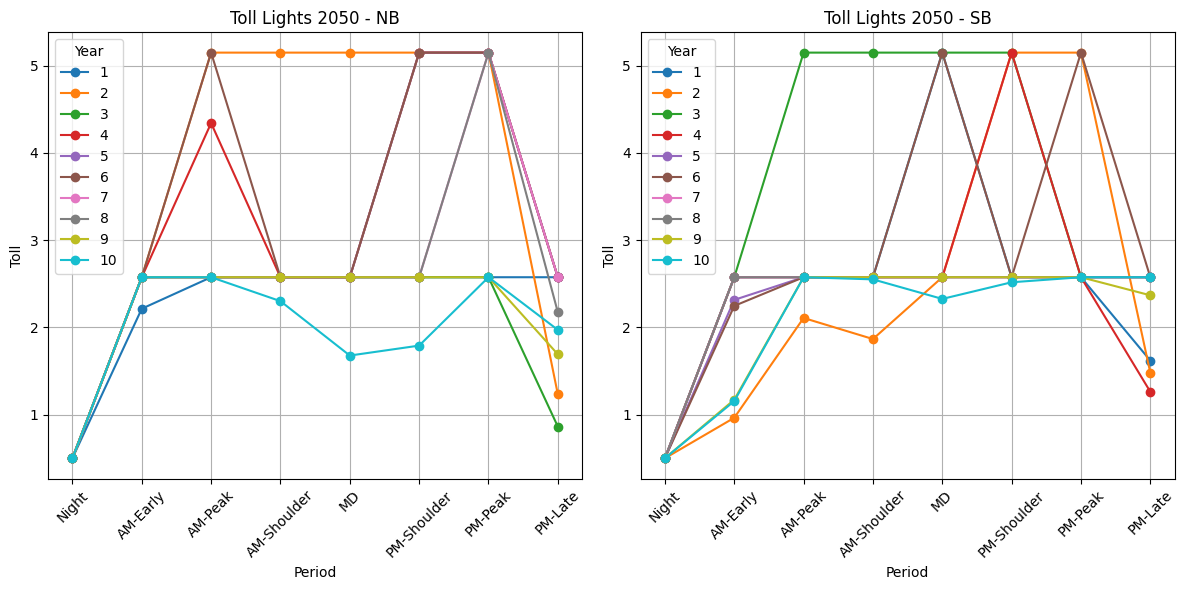

In [101]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Cargar CSV
# model_run = pd.read_csv("outputs\\2025-09-02\\19-01-04_1\\model_run.csv")
# model_run = pd.read_csv("outputs\\2025-09-10\\18-28-56_1\\model_run.csv")
# model_run = pd.read_csv("outputs\\2025-09-12\\18-59-17_1\\model_run.csv")
model_run = pd.read_csv(f"{run_folder}\\model_run.csv")

# model_run = pd.read_csv("outputs\\2025-10-02\\cap_v2\\model_run.csv")

year_val = 2050

model_run = model_run.loc[model_run["Year"] == year_val]

model_run.loc[model_run['Period'] == 'Night', 'TollLights'] = 0.5

# 2. Definir años y direcciones
segments = [1,2,3,4,5,6,7,8,9,10]
directions = ["NB", "SB"]

plt.figure(figsize=(12, 6))

for i, direction in enumerate(directions, 1):
    plt.subplot(1, 2, i)
    for segment in segments:
        df = model_run[(model_run["Segment"] == segment) & (model_run["Direction"] == direction)]
        plt.plot(df["Period"], df["TollLights"], marker='o', linestyle='-', label=str(segment))
        
    
    plt.title(f"Toll Lights {year_val} - {direction}")
    plt.xlabel("Period")
    plt.ylabel("Toll")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend(title="Year")

plt.tight_layout()
plt.show()

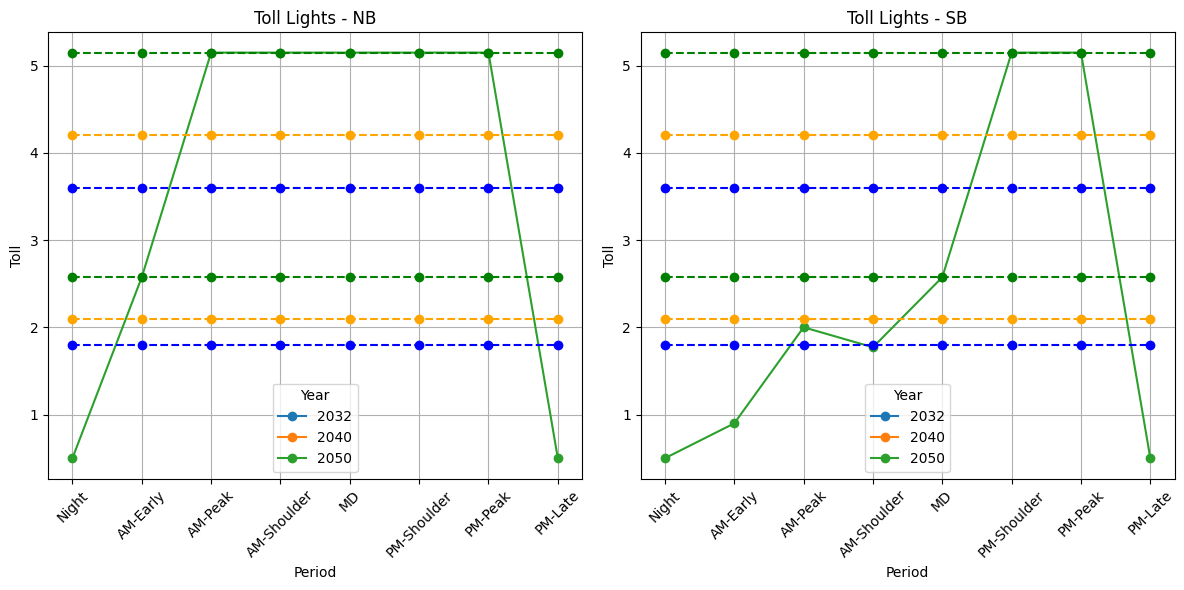

In [102]:
import pandas as pd
import matplotlib.pyplot as plt

# model_run = pd.read_csv("outputs\\2025-09-12\\18-59-17_1\\model_run.csv")
# model_run = pd.read_csv("outputs\\2025-09-11\\total_v1\\model_run.csv")
# model_run = pd.read_csv("outputs\\2025-09-10\\18-28-56_1\\model_run.csv")
model_run = pd.read_csv(f"outputs\\2025-10-08\\test_new_cap_v3\\model_run.csv")
# model_run = pd.read_csv("outputs\\2025-09-15\\cap_categories_v1\\model_run.csv")
# model_run = pd.read_csv("outputs\\2025-09-18\\15-26-30_1\\model_run.csv")
# model_run = pd.read_csv("outputs\\2025-10-02\\cap_v2\\model_run.csv")

# model_run = pd.read_csv(f"{run_folder}\\model_run.csv")

years = [2032, 2040, 2050]
directions = ["NB", "SB"]

model_run = model_run.loc[model_run["Segment"] == 2] #2

model_run.loc[model_run['Period'] == 'Night', 'TollLights'] = 0.5
model_run.loc[model_run['Period'] == 'PM-Late', 'TollLights'] = 0.5

plt.figure(figsize=(12, 6))

for i, direction in enumerate(directions, 1):
    plt.subplot(1, 2, i)
        
    for year in years:
        df = model_run[(model_run["Year"] == year) & (model_run["Direction"] == direction)]
        #if year == 2050:
        #    df["TollLights"] = df["TollLights"].clip(upper=5.15)
        #if year == 2040:
        #    df["TollLights"] = df["TollLights"].clip(upper=4.2)
        #if year == 2032:
        #    df["TollLights"] = df["TollLights"].clip(upper=3.6)

        plt.plot(df["Period"], df["TollLights"], marker='o', linestyle='-', label=str(year))   
    
    
    df_cap_50 = pd.DataFrame({"Value": [5.15] * 8})
    df_cap_40 = pd.DataFrame({"Value": [4.2] * 8})
    df_cap_32 = pd.DataFrame({"Value": [3.6] * 8})
    plt.plot(df["Period"], df_cap_50["Value"], marker='o', linestyle='--', color='green') 
    plt.plot(df["Period"], df_cap_40["Value"], marker='o', linestyle='--', color='orange') 
    plt.plot(df["Period"], df_cap_32["Value"], marker='o', linestyle='--', color='blue')
    df_cap_s50 = pd.DataFrame({"Value": [5.15/2] * 8})
    df_cap_s40 = pd.DataFrame({"Value": [4.2/2] * 8})
    df_cap_s32 = pd.DataFrame({"Value": [3.6/2] * 8})
    plt.plot(df["Period"], df_cap_s50["Value"], marker='o', linestyle='--', color='green') 
    plt.plot(df["Period"], df_cap_s40["Value"], marker='o', linestyle='--', color='orange') 
    plt.plot(df["Period"], df_cap_s32["Value"], marker='o', linestyle='--', color='blue') 

    plt.title(f"Toll Lights - {direction}")
    plt.xlabel("Period")
    plt.ylabel("Toll")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend(title="Year")

plt.tight_layout()
plt.show()

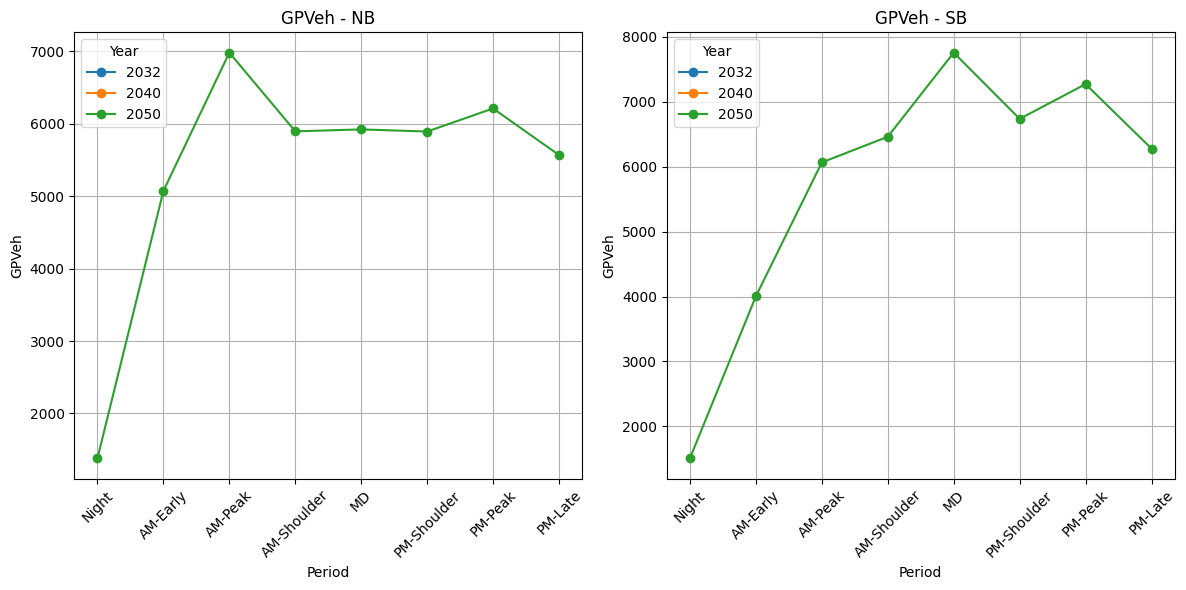

In [103]:
import pandas as pd
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

for i, direction in enumerate(directions, 1):
    plt.subplot(1, 2, i)
    
    for year in years:
        df = model_run[(model_run["Year"] == year) & (model_run["Direction"] == direction)]
        plt.plot(df["Period"], df["GPVeh"], marker='o', linestyle='-', label=str(year))
    
    plt.title(f"GPVeh - {direction}")
    plt.xlabel("Period")
    plt.ylabel("GPVeh")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend(title="Year")

plt.tight_layout()
plt.show()

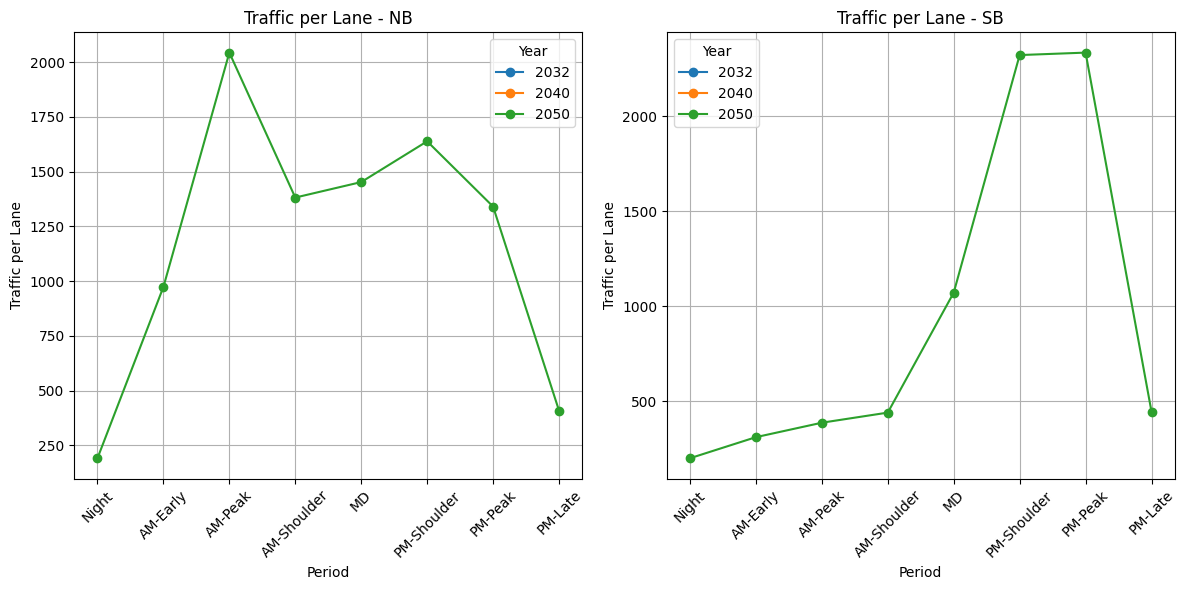

In [104]:
import pandas as pd
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

for i, direction in enumerate(directions, 1):
    plt.subplot(1, 2, i)
    
    for year in years:
        df = model_run[(model_run["Year"] == year) & (model_run["Direction"] == direction)]
        plt.plot(df["Period"], df["ML PCE"] / 2, marker='o', linestyle='-', label=str(year))
    
    plt.title(f"Traffic per Lane - {direction}")
    plt.xlabel("Period")
    plt.ylabel("Traffic per Lane")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend(title="Year")

plt.tight_layout()
plt.show()

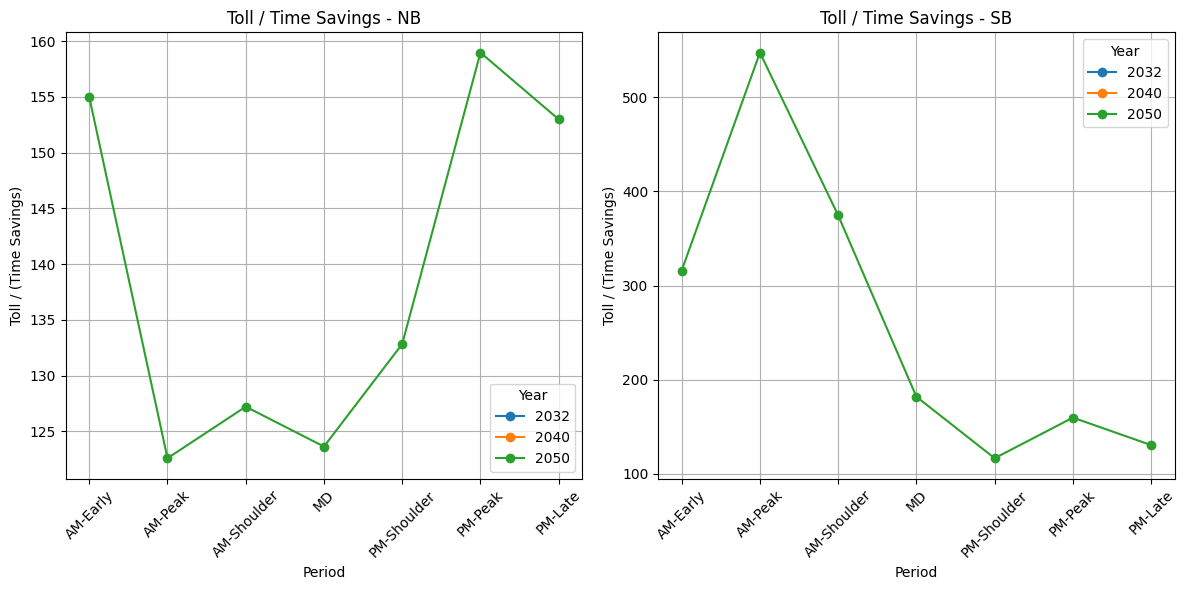

In [105]:
import pandas as pd
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

for i, direction in enumerate(directions, 1):
    plt.subplot(1, 2, i)
    
    for year in years:
        df = model_run[(model_run["Year"] == year) & (model_run["Direction"] == direction) & (model_run["Period"] != 'Night')]
        plt.plot(df["Period"], (60 * df["TollLights"] / (df["Time GP"] - df["Time ML"])), marker='o', linestyle='-', label=str(year))
    
    plt.title(f"Toll / Time Savings - {direction}")
    plt.xlabel("Period")
    plt.ylabel("Toll / (Time Savings)")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend(title="Year")

plt.tight_layout()
plt.show()

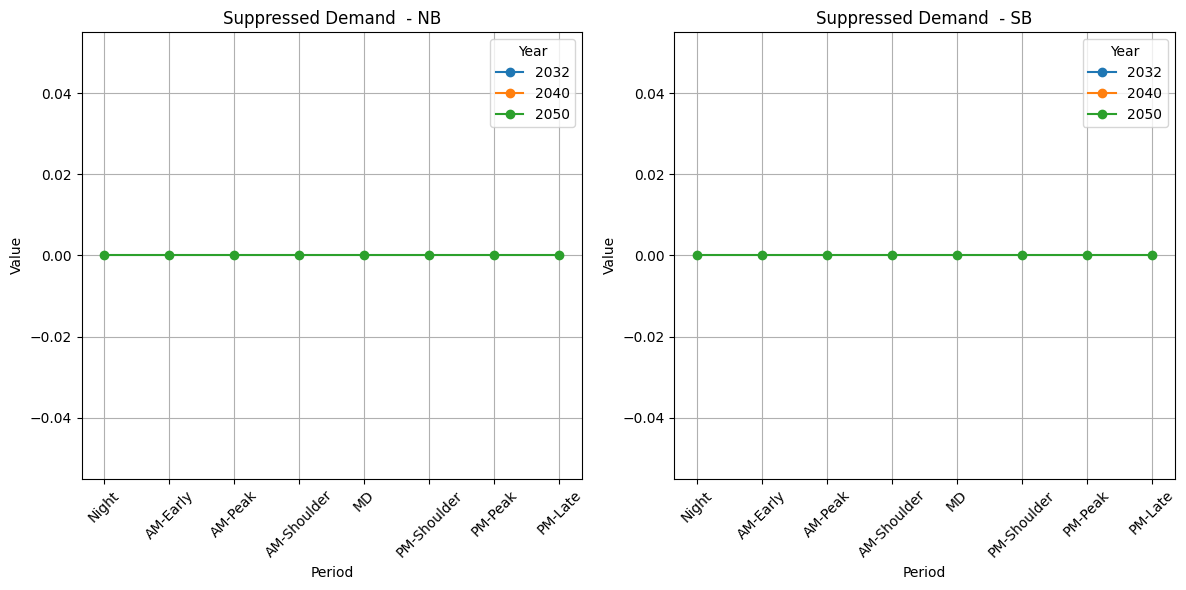

In [106]:
import pandas as pd
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

for i, direction in enumerate(directions, 1):
    plt.subplot(1, 2, i)
    
    for year in years:
        df = model_run[(model_run["Year"] == year) & (model_run["Direction"] == direction)]
        plt.plot(df["Period"], df["Suppressed Demand"], marker='o', linestyle='-', label=str(year))
    
    plt.title(f"Suppressed Demand  - {direction}")
    plt.xlabel("Period")
    plt.ylabel("Value")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend(title="Year")

plt.tight_layout()
plt.show()

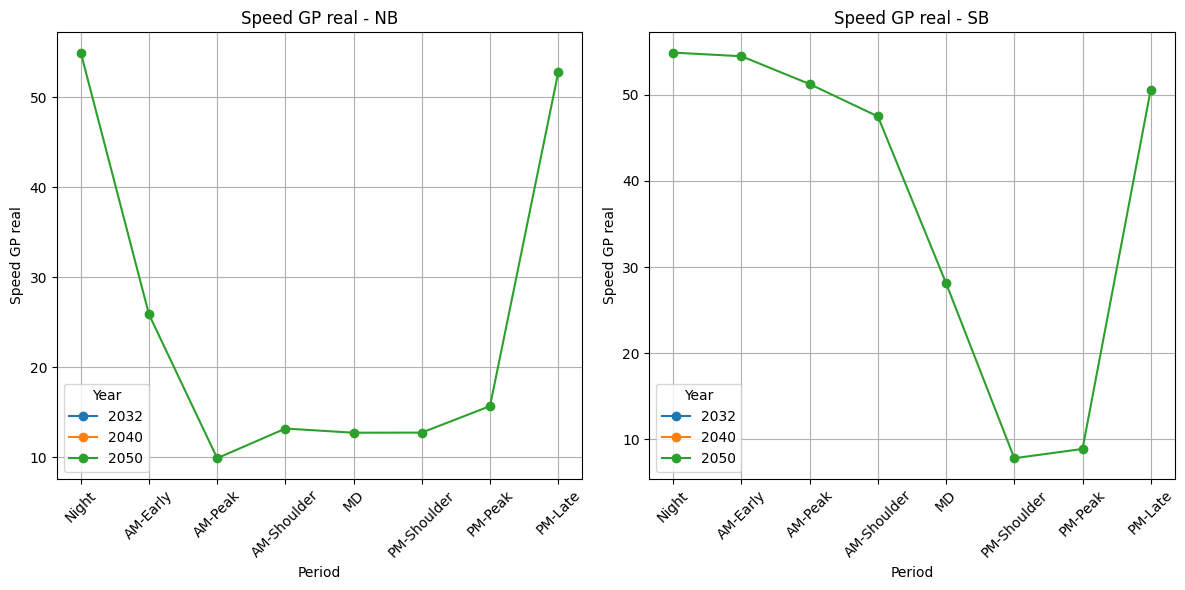

In [107]:
import pandas as pd
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

for i, direction in enumerate(directions, 1):
    plt.subplot(1, 2, i)
    
    for year in years:
        df = model_run[(model_run["Year"] == year) & (model_run["Direction"] == direction)]
        plt.plot(df["Period"], df["Speed GP Real"], marker='o', linestyle='-', label=str(year))
    
    plt.title(f"Speed GP real - {direction}")
    plt.xlabel("Period")
    plt.ylabel("Speed GP real")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend(title="Year")

plt.tight_layout()
plt.show()

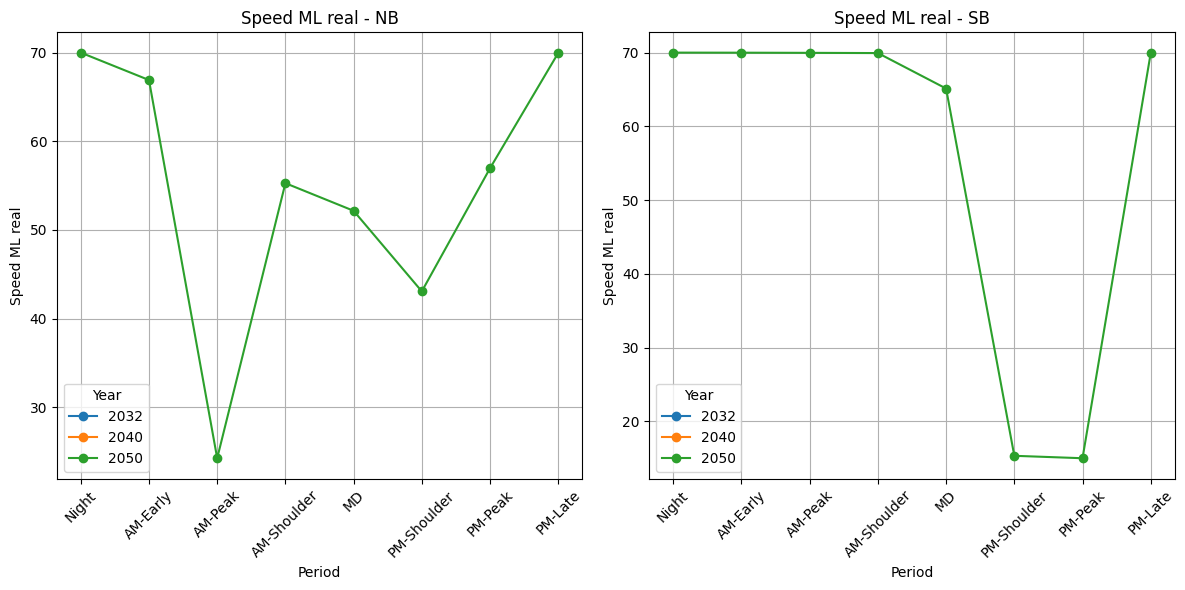

In [108]:
import pandas as pd
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

for i, direction in enumerate(directions, 1):
    plt.subplot(1, 2, i)
    
    for year in years:
        df = model_run[(model_run["Year"] == year) & (model_run["Direction"] == direction)]
        plt.plot(df["Period"], df["Speed ML Real"], marker='o', linestyle='-', label=str(year))
    
    plt.title(f"Speed ML real - {direction}")
    plt.xlabel("Period")
    plt.ylabel("Speed ML real")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend(title="Year")

plt.tight_layout()
plt.show()

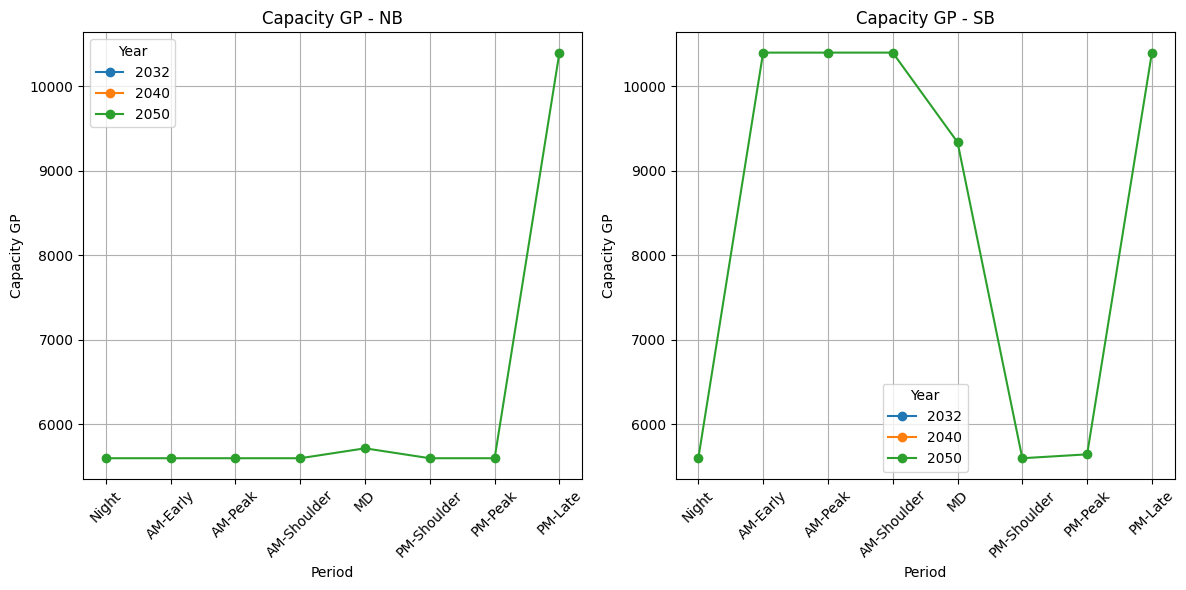

In [109]:
import pandas as pd
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

for i, direction in enumerate(directions, 1):
    plt.subplot(1, 2, i)
    
    for year in years:
        df = model_run[(model_run["Year"] == year) & (model_run["Direction"] == direction)]
        plt.plot(df["Period"], df["Capacity GP"], marker='o', linestyle='-', label=str(year))
    
    plt.title(f"Capacity GP - {direction}")
    plt.xlabel("Period")
    plt.ylabel("Capacity GP")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend(title="Year")

plt.tight_layout()
plt.show()

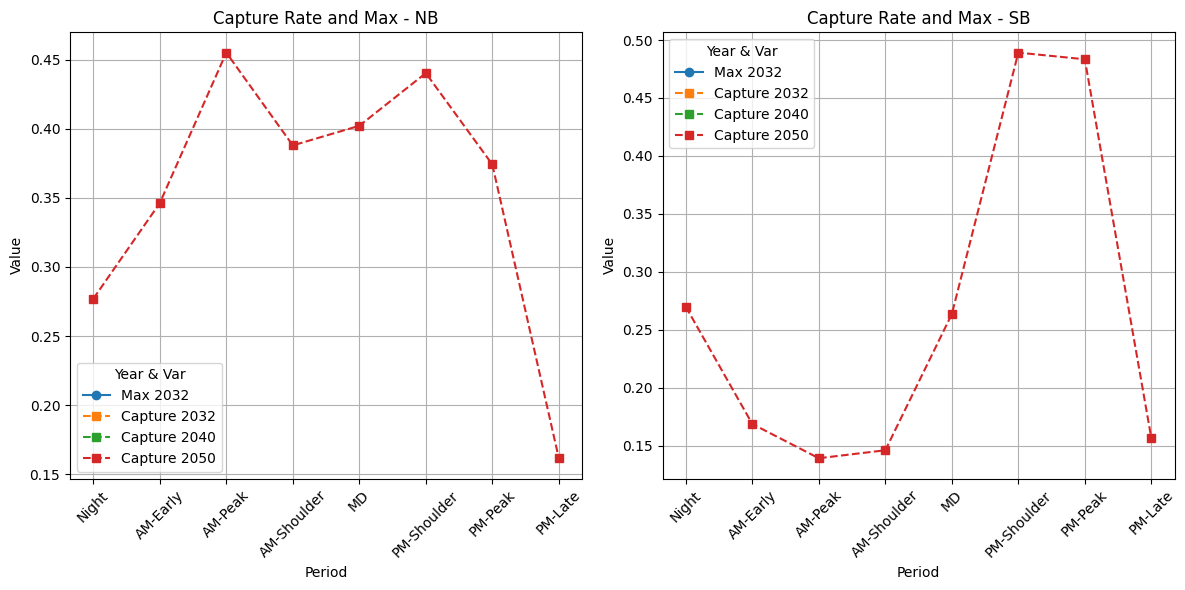

In [110]:
import pandas as pd
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

for i, direction in enumerate(directions, 1):
    plt.subplot(1, 2, i)
    
    for year in years:
        df = model_run[(model_run["Year"] == year) & (model_run["Direction"] == direction)]
        
        # Graficar Capture
        if year == years[0]:
            plt.plot(df["Period"], df["MaxCapture"], marker='o', linestyle='-', label=f"Max {year}")
        # Graficar Toll
        plt.plot(df["Period"], df["CaptureRateLights"], marker='s', linestyle='--', label=f"Capture {year}")
    
    plt.title(f"Capture Rate and Max - {direction}")
    plt.xlabel("Period")
    plt.ylabel("Value")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend(title="Year & Var")

plt.tight_layout()
plt.show()


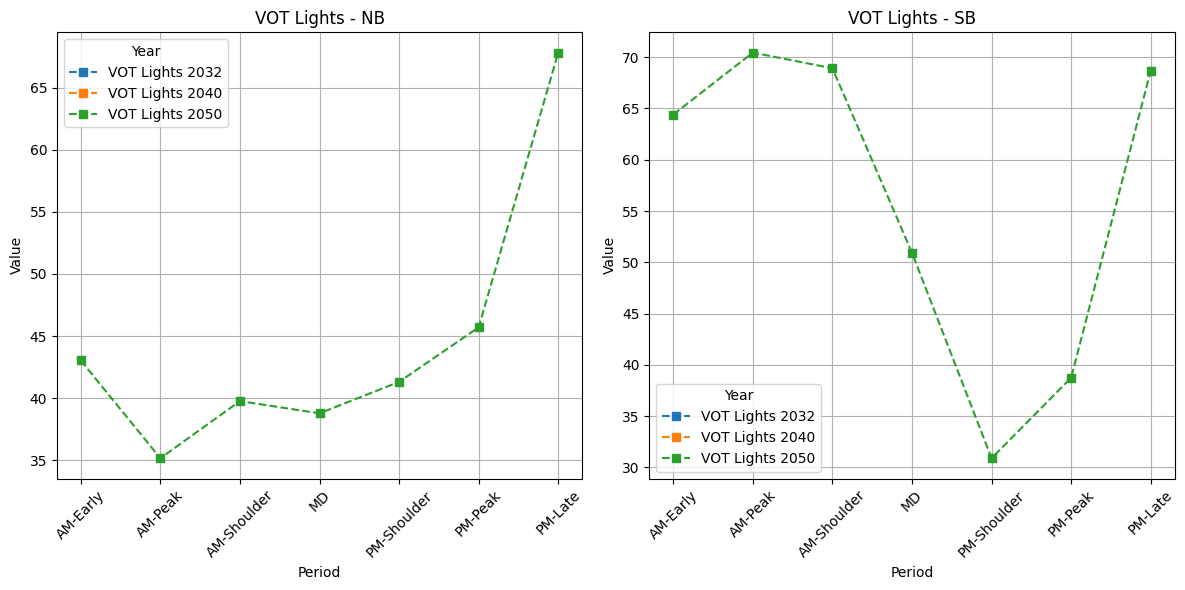

In [111]:
import pandas as pd
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

for i, direction in enumerate(directions, 1):
    plt.subplot(1, 2, i)
    
    for year in years:
        df = model_run[(model_run["Year"] == year) & (model_run["Direction"] == direction) & (model_run["Period"] != "Night")]

        # Graficar Toll
        plt.plot(df["Period"], df["VOT Lights"], marker='s', linestyle='--', label=f"VOT Lights {year}")
    
    plt.title(f"VOT Lights - {direction}")
    plt.xlabel("Period")
    plt.ylabel("Value")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend(title="Year")

plt.tight_layout()
plt.show()
